### INSY 662 Team Project
Team members: David Gao, Farah Hoque, Kritika Nayyar, Tashfeen Ahmed, Yifan Lu

Import crime data using API

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sodapy import Socrata

client = Socrata("data.lacity.org", None)
results = client.get("2nrs-mtv8", limit=20000000)

# Convert to pandas DataFrame
raw_df = pd.DataFrame.from_records(results)

In [4]:
# Display column names
print("Column Names:", raw_df.columns, '\n')

# Display DataFrame shape
print("DataFrame Shape:", raw_df.shape, '\n')

# Display the first 5 rows using HTML formatting
display(HTML(raw_df.head().to_html()))

Column Names: Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'location', 'lat', 'lon', 'crm_cd_2', 'cross_street', 'crm_cd_3',
       'crm_cd_4'],
      dtype='object') 

DataFrame Shape: (838901, 28) 



,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,location,lat,lon,crm_cd_2,cross_street,crm_cd_3,crm_cd_4
0,010304468,2020-01-08T00:00:00.000,2020-01-08T00:00:00.000,2230,03,Southwest,0377,2,624,BATTERY - SIMPLE ASSAULT,0444 0913,36,F,B,501,SINGLE FAMILY DWELLING,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,624,1100 W 39TH PL,34.0141,-118.2978,NaN,NaN,NaN,NaN
1,190101086,2020-01-02T00:00:00.000,2020-01-01T00:00:00.000,0330,01,Central,0163,2,624,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25,M,H,102,SIDEWALK,500,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,624,700 S HILL ST,34.0459,-118.2545,NaN,NaN,NaN,NaN
2,200110444,2020-04-14T00:00:00.000,2020-02-13T00:00:00.000,1200,01,Central,0155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,1501,0,X,X,726,POLICE FACILITY,NaN,NaN,AA,Adult Arrest,845,200 E 6TH ST,34.0448,-118.2474,NaN,NaN,NaN,NaN
3,191501505,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1402,76,F,W,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,745,5400 CORTEEN PL,34.1685,-118.4019,998,NaN,NaN,NaN
4,191921269,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,0415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",0329,31,X,X,409,BEAUTY SUPPLY STORE,NaN,NaN,IC,Invest Cont,740,14400 TITUS ST,34.2198,-118.4468,NaN,NaN,NaN,NaN


In [5]:
# Check for null values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(raw_df.isnull().sum())

dr_no                  0
date_rptd              0
date_occ               0
time_occ               0
area                   0
area_name              0
rpt_dist_no            0
part_1_2               0
crm_cd                 0
crm_cd_desc            0
mocodes           116254
vict_age               0
vict_sex          110555
vict_descent      110563
premis_cd             10
premis_desc          506
weapon_used_cd    546510
weapon_desc       546510
status                 0
status_desc            0
crm_cd_1              11
location               0
lat                    0
lon                    0
crm_cd_2          777267
cross_street      705089
crm_cd_3          836820
crm_cd_4          838840
dtype: int64


In [6]:
# Drop unnecessary columns
unneccessary_columns = ['dr_no','date_rptd','area_name','rpt_dist_no','part_1_2','crm_cd_desc',
                        'premis_desc','status','crm_cd_1','location']
raw_df1=raw_df.drop(unneccessary_columns,axis=1)

# Drop columns with a lot of null values
columns_with_missing_values = ['mocodes','weapon_used_cd','weapon_desc','crm_cd_2','crm_cd_3',
                               'crm_cd_4','cross_street']
raw_df1=raw_df1.drop(columns_with_missing_values,axis=1)

raw_df1.shape # (838901, 11)

(838901, 11)

In [7]:
# Drop rows with any missing values (NaN) from the DataFrame 'raw_df1'
raw_df1 = raw_df1.dropna()

# Display the shape of the DataFrame after dropping missing values
print("After dropping missing values:")
print(raw_df1.shape)  # Output: (728333, 11)

After dropping missing values:
(728333, 11)


In [8]:
# Drop duplicate rows from the DataFrame 'raw_df1'
raw_df1.drop_duplicates(inplace=True)

# Display the shape of the DataFrame after dropping duplicates
print("After dropping duplicates:")
print(raw_df1.shape)  # Output: (725532, 11)

After dropping duplicates:
(725532, 11)


In [9]:
# The below code is transforming the date and time columns in the DataFrame (raw_df1) to a 
# specific format and creating new columns to store the formatted information

# Convert the 'date_occ' column to datetime format
raw_df1['date_occ'] = pd.to_datetime(raw_df1['date_occ'])

# Convert the 'date_occ' column to string format
raw_df1['date_occ'] = raw_df1['date_occ'].astype(str)

# Split the 'date_occ' column into 'year', 'month', and 'day' columns, and convert them to integers
raw_df1[['year', 'month', 'day']] = raw_df1['date_occ'].str.split('-', expand=True).astype(int)

# Convert the 'time_occ' column to string format
raw_df1['time_occ'] = raw_df1['time_occ'].astype(str)

# Use the lambda function to left-fill the 'time_occ' column with zeros to make it four characters long
raw_df1['time_occ'] = raw_df1['time_occ'].apply(lambda x: x.zfill(4))

# Create a new column 'rounded_crime_time' with the standard time format
raw_df1['rounded_crime_time'] = raw_df1['time_occ'].str[:2] + ':' + raw_df1['time_occ'].str[2:] 

# Convert 'rounded_crime_time' to datetime format with format='%H:%M'
raw_df1['rounded_crime_time'] = pd.to_datetime(raw_df1['rounded_crime_time'], format='%H:%M')

# Round the time to the nearest hour and extract the time part
raw_df1['rounded_crime_time'] = raw_df1['rounded_crime_time'].dt.round('H').dt.time

# Convert 'rounded_crime_time' to datetime format with format='%H:%M:%S'
raw_df1['rounded_crime_time'] = pd.to_datetime(raw_df1['rounded_crime_time'], format='%H:%M:%S')

# Convert 'rounded_crime_time' to string format with format='%H:%M'
raw_df1['rounded_crime_time'] = raw_df1['rounded_crime_time'].dt.strftime('%H:%M')

display(HTML(raw_df1.head().to_html()))

,date_occ,time_occ,area,crm_cd,vict_age,vict_sex,vict_descent,premis_cd,status_desc,lat,lon,year,month,day,rounded_crime_time
0,2020-01-08,2230,03,624,36,F,B,501,Adult Other,34.0141,-118.2978,2020,1,8,22:00
1,2020-01-01,0330,01,624,25,M,H,102,Invest Cont,34.0459,-118.2545,2020,1,1,04:00
2,2020-02-13,1200,01,845,0,X,X,726,Adult Arrest,34.0448,-118.2474,2020,2,13,12:00
3,2020-01-01,1730,15,745,76,F,W,502,Invest Cont,34.1685,-118.4019,2020,1,1,18:00
4,2020-01-01,0415,19,740,31,X,X,409,Invest Cont,34.2198,-118.4468,2020,1,1,04:00


In [10]:
summary_df = pd.DataFrame({
    'Missing Values': raw_df1.isnull().sum(),
    'Unique Values': raw_df1.nunique(),
    'Data Type': raw_df1.dtypes,
    'Number of Duplicates': raw_df1.duplicated().sum()
})

display(HTML(summary_df.to_html()))

,Missing Values,Unique Values,Data Type,Number of Duplicates
date_occ,0,1413,object,0
time_occ,0,1439,object,0
area,0,21,object,0
crm_cd,0,137,object,0
vict_age,0,102,object,0
vict_sex,0,5,object,0
vict_descent,0,20,object,0
premis_cd,0,313,object,0
status_desc,0,6,object,0
lat,0,5446,object,0


The below lines of code is cleaning the DataFrame by removing rows with specific values ('-', 'X') in the 'vict_sex' and 'vict_descent' columns. Additionally, it filters out rows where the 'vict_age' is less than '0'. The counts and shape are displayed at different steps for a better understanding of the data cleaning process.

In [11]:
# Display the count of unique values in the 'vict_sex' column
vict_sex_counts = raw_df1['vict_sex'].value_counts() # X: 72615, '-': 1

# Print the counts for each unique value in 'vict_sex'
print("Counts for 'vict_sex':")
print(vict_sex_counts)

# Display the count of unique values in the 'vict_descent' column
vict_descent_counts = raw_df1['vict_descent'].value_counts() # X: 80097 '-': 2

# Print the counts for each unique value in 'vict_descent'
print("Counts for 'vict_descent':")
print(vict_descent_counts)

Counts for 'vict_sex':
M    344638
F    308187
X     72615
H        91
-         1
Name: vict_sex, dtype: int64
Counts for 'vict_descent':
H    256432
W    170340
B    118979
X     80097
O     66237
A     18384
K      4486
F      3494
C      3241
J      1156
V       870
I       786
Z       416
P       225
U       166
D        64
G        60
L        51
S        46
-         2
Name: vict_descent, dtype: int64


In [12]:
# Count the number of rows where 'vict_sex' is 'X' and 'vict_descent' is 'X'
count = ((raw_df1['vict_sex'] == 'X') & (raw_df1['vict_descent'] == 'X')).sum()
count # 71987

71987

In [13]:
# Delete rows where 'vict_sex' is '-' or 'X' and 'vict_descent' is 'X'
raw_df1 = raw_df1[(raw_df1['vict_sex'] != '-') & (raw_df1['vict_sex'] != 'X')] # (652916, 15)

In [14]:
# Delete rows where 'vict_descent' is 'X'
raw_df1 = raw_df1[raw_df1['vict_descent'] != 'X'] # (644806, 15)

In [15]:
# Filter rows where 'vict_age' is greater than or equal to '0'
raw_df1 = raw_df1[(raw_df1['vict_age'] >= '0')] # (644783, 15)

### Data Exploration

In [16]:
raw_df1.describe()

,year,month,day
count,644783.000000,644783.000000,644783.000000
mean,2021.493299,6.327940,15.187429
std,1.087589,3.357636,8.997015
min,2020.000000,1.000000,1.000000
25%,2021.000000,3.000000,7.000000
50%,2022.000000,6.000000,15.000000
75%,2022.000000,9.000000,23.000000
max,2023.000000,12.000000,31.000000


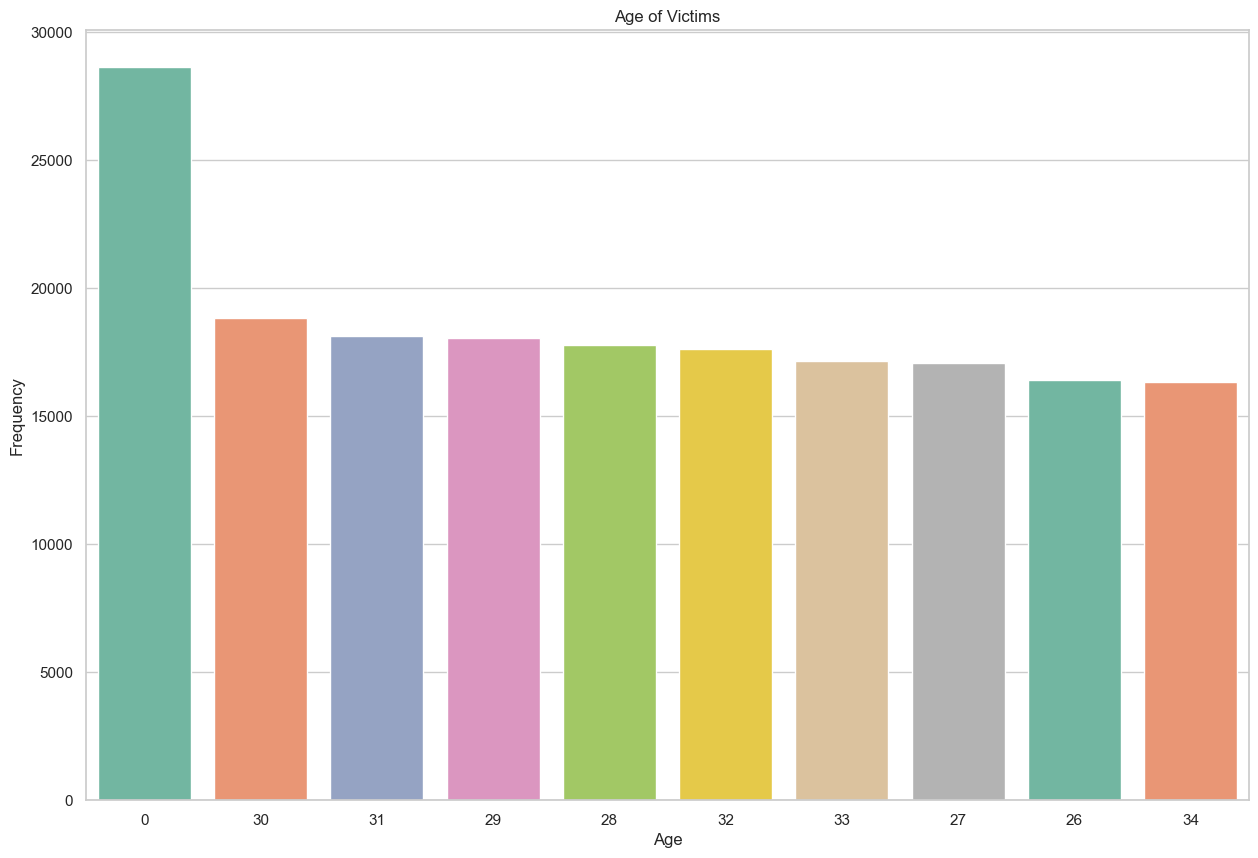

In [17]:
# Plot a bar chart of the top 10 victim ages using Seaborn, with customized style and formatting
sns.set(style="whitegrid")
plt.figure(figsize=(15,10))
top_ages = raw_df1['vict_age'].value_counts().head(10)
sns.barplot(x=top_ages.index, y=top_ages.values, palette="Set2")
plt.title('Age of Victims')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Investigate rows where the victim age is '0' in the DataFrame
raw_df1[raw_df1['vict_age']=='0'] # (644783, 15)

# Delete rows where the victim age is '0' in the DataFrame
raw_df1 = raw_df1[raw_df1['vict_age']!='0'] # (616136, 15)

display(HTML(raw_df1.head().to_html()))

,date_occ,time_occ,area,crm_cd,vict_age,vict_sex,vict_descent,premis_cd,status_desc,lat,lon,year,month,day,rounded_crime_time
0,2020-01-08,2230,03,624,36,F,B,501,Adult Other,34.0141,-118.2978,2020,1,8,22:00
1,2020-01-01,0330,01,624,25,M,H,102,Invest Cont,34.0459,-118.2545,2020,1,1,04:00
3,2020-01-01,1730,15,745,76,F,W,502,Invest Cont,34.1685,-118.4019,2020,1,1,18:00
5,2020-01-01,0030,01,121,25,F,H,735,Invest Cont,34.0452,-118.2534,2020,1,1,00:00
6,2020-01-02,1315,01,442,23,M,H,404,Invest Cont,34.0483,-118.2631,2020,1,2,13:00


Weather data

Dont run weather api code again to avoid API charges

In [19]:
#import urllib.request
#import pandas as pd
#
#try:
#    url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/los%20angeles/2020-01-01/2022-08-31?unitGroup=metric&include=days&key=U9MTPEEWF73ZN3ZCJUS8JABMY&contentType=csv"
#    weather_df_2020_2022_August = pd.read_csv(url)
#except Exception as e:
#    print("An error occurred:", str(e))


In [20]:
#file_path = r'D:\Google Drive\McGill\Fall Semester\INSY 662\Team Project\Data\Weather\Daily Weather\weather_df_2020_2022_August.csv'
#
## Save the DataFrame to a CSV file
#weather_df_2020_2022_August.to_csv(file_path, index=False)


In [21]:
#try:
#    url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/los%20angeles/2022-09-01/2023-10-29?unitGroup=metric&include=days&key=7AMU6SK9AT9D4G9Q9XPZPKV7K&contentType=csv"
#    weather_df_2022_Sept_2023 = pd.read_csv(url)
#except Exception as e:
#    print("An error occurred:", str(e))


In [22]:
#file_path = r'D:\Google Drive\McGill\Fall Semester\INSY 662\Team Project\Data\Weather\Daily Weather\weather_data_2022_2023.csv'
#
#weather_df_2022_Sept_2023.to_csv(file_path, index=False)

In [23]:
#weather_df=pd.concat([weather_df_2020_2022_August,weather_df_2022_Sept_2023],ignore_index=True)

In [24]:
#file_path = r'D:\Google Drive\McGill\Fall Semester\INSY 662\Team Project\Data\Weather\Daily Weather\weather_df.csv'

#weather_df.to_csv(file_path, index=False)

Preprocessing Weather Data

In [25]:
# Read weather data from the CSV file into a DataFrame 'weather_df'
weather_df = pd.read_csv('weather_df.csv')

# Display the shape of the weather DataFrame
print("Weather DataFrame Shape:", weather_df.shape)  # Output: (1398, 33)

# Display the first 5 rows of the weather DataFrame using HTML formatting
display(HTML(weather_df.head().to_html()))

Weather DataFrame Shape: (1398, 33)


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Los Angeles, CA, United States",2020-01-01,20.8,10.0,15.2,20.8,10.0,15.2,3.8,48.9,0.0,0.0,0.0,NaN,0,0,NaN,12.0,27.6,1015.7,1.9,15.3,136.8,11.9,5,NaN,2020-01-01T06:58:38,2020-01-01T16:54:25,0.21,Clear,Clear conditions throughout the day.,clear-day,"A2968,KHHR,72295023174,KBUR,KCQT,72295603167,72287493134,CQ070"
1,"Los Angeles, CA, United States",2020-01-02,20.4,10.8,14.8,20.4,10.8,14.8,9.1,69.6,0.0,0.0,0.0,NaN,0,0,NaN,11.1,73.1,1014.6,8.8,14.1,121.4,10.4,5,NaN,2020-01-02T06:58:50,2020-01-02T16:55:10,0.25,Clear,Clear conditions throughout the day.,clear-day,"A2968,KHHR,72295023174,KBUR,KCQT,72295603167,72287493134,CQ070"
2,"Los Angeles, CA, United States",2020-01-03,23.5,10.9,16.2,23.5,10.9,16.2,5.6,53.0,0.0,0.0,0.0,NaN,0,0,NaN,8.1,306.1,1022.6,2.2,15.7,129.1,11.2,5,NaN,2020-01-03T06:58:59,2020-01-03T16:55:57,0.28,Clear,Clear conditions throughout the day.,clear-day,"A2968,KHHR,72295023174,KBUR,KCQT,72295603167,72287493134,CQ070"
3,"Los Angeles, CA, United States",2020-01-04,21.4,9.8,14.7,21.4,9.8,14.7,7.4,63.6,0.0,0.0,0.0,NaN,0,0,NaN,6.6,284.8,1025.9,1.2,14.0,135.5,11.8,5,NaN,2020-01-04T06:59:07,2020-01-04T16:56:44,0.31,Clear,Clear conditions throughout the day.,clear-day,"A2968,KHHR,72295023174,KBUR,KCQT,72295603167,72287493134,CQ070"
4,"Los Angeles, CA, United States",2020-01-05,21.4,9.3,14.5,21.4,9.3,14.5,5.9,59.1,0.0,0.0,0.0,NaN,0,0,29.5,8.6,311.2,1024.2,2.2,15.0,136.5,11.6,6,NaN,2020-01-05T06:59:13,2020-01-05T16:57:33,0.34,Clear,Clear conditions throughout the day.,clear-day,"A2968,KHHR,72295023174,KBUR,KCQT,72295603167,72287493134,CQ070"


In [26]:
# Display descriptive statistics for all columns in the 'weather_df' DataFrame
# Set display options to show all rows and columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(weather_df.describe())

           tempmax      tempmin         temp  feelslikemax  feelslikemin  \
count  1398.000000  1398.000000  1398.000000   1398.000000   1398.000000   
mean     23.303290    14.329971    18.250644     23.244206     14.294134   
std       4.917116     4.168635     4.037946      4.838131      4.227763   
min      10.700000    -3.500000     8.300000     10.700000     -3.500000   
25%      19.700000    11.100000    15.000000     19.700000     11.100000   
50%      23.200000    14.700000    18.100000     23.200000     14.700000   
75%      26.600000    17.600000    21.300000     26.500000     17.600000   
max      41.800000    26.300000    32.400000     42.300000     26.300000   

         feelslike          dew     humidity       precip   precipprob  \
count  1398.000000  1398.000000  1398.000000  1398.000000  1398.000000   
mean     18.229828     9.928684    62.274034     0.873124    11.476538   
std       4.045005     5.919577    14.283090     4.849724    31.839994   
min       7.400000 

By comparing min max and mean values for all variables, there seems to be no outliers

In [27]:
# Select specific columns from the 'weather_df' DataFrame to be used in the model
weather_df1 = weather_df[['datetime', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip', 'precipprob',
                          'precipcover', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
                          'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase', 'conditions']]

# Display the shape of the weather DataFrame
print("Weather DataFrame Shape:", weather_df1.shape)  # Output: (1398, 21)

display(HTML(weather_df1.head().to_html()))

Weather DataFrame Shape: (1398, 21)


,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions
0,2020-01-01,20.8,10.0,15.2,3.8,48.9,0.0,0.0,0.0,12.0,27.6,1015.7,1.9,15.3,136.8,11.9,5,2020-01-01T06:58:38,2020-01-01T16:54:25,0.21,Clear
1,2020-01-02,20.4,10.8,14.8,9.1,69.6,0.0,0.0,0.0,11.1,73.1,1014.6,8.8,14.1,121.4,10.4,5,2020-01-02T06:58:50,2020-01-02T16:55:10,0.25,Clear
2,2020-01-03,23.5,10.9,16.2,5.6,53.0,0.0,0.0,0.0,8.1,306.1,1022.6,2.2,15.7,129.1,11.2,5,2020-01-03T06:58:59,2020-01-03T16:55:57,0.28,Clear
3,2020-01-04,21.4,9.8,14.7,7.4,63.6,0.0,0.0,0.0,6.6,284.8,1025.9,1.2,14.0,135.5,11.8,5,2020-01-04T06:59:07,2020-01-04T16:56:44,0.31,Clear
4,2020-01-05,21.4,9.3,14.5,5.9,59.1,0.0,0.0,0.0,8.6,311.2,1024.2,2.2,15.0,136.5,11.6,6,2020-01-05T06:59:13,2020-01-05T16:57:33,0.34,Clear


In [28]:
# Check for the number of missing values in each column of the 'weather_df1' DataFrame
weather_df1.isnull().sum()

datetime            0
tempmax             0
tempmin             0
temp                0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
sunrise             0
sunset              0
moonphase           0
conditions          0
dtype: int64

In [29]:
# Check for the number of duplicated rows in the 'weather_df1' DataFrame
weather_df1.duplicated().sum()

0

In [30]:
# Display the data types of each column in the 'weather_df1' DataFrame
weather_df1.dtypes

datetime             object
tempmax             float64
tempmin             float64
temp                float64
dew                 float64
humidity            float64
precip              float64
precipprob          float64
precipcover         float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex               int64
sunrise              object
sunset               object
moonphase           float64
conditions           object
dtype: object

Convert time values into 24 hours format

In [31]:
# Convert the 'datetime' column to datetime format
weather_df1['datetime'] = pd.to_datetime(weather_df1['datetime'])

# Split the 'datetime' column into 'year', 'month', and 'day' columns
weather_df1['year'] = weather_df1['datetime'].dt.year
weather_df1['month'] = weather_df1['datetime'].dt.month
weather_df1['day'] = weather_df1['datetime'].dt.day

# Display the first 5 rows of the 'weather_df1' DataFrame after the datetime column split
display(HTML(weather_df1.head().to_html()))

/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_22523/2689447400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df1['datetime'] = pd.to_datetime(weather_df1['datetime'])
/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_22523/2689447400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df1['year'] = weather_df1['datetime'].dt.year
/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_22523/2689447400.py:6: SettingWithCopyWarning: 
A value is trying to be set o

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions,year,month,day
0,2020-01-01,20.8,10.0,15.2,3.8,48.9,0.0,0.0,0.0,12.0,27.6,1015.7,1.9,15.3,136.8,11.9,5,2020-01-01T06:58:38,2020-01-01T16:54:25,0.21,Clear,2020,1,1
1,2020-01-02,20.4,10.8,14.8,9.1,69.6,0.0,0.0,0.0,11.1,73.1,1014.6,8.8,14.1,121.4,10.4,5,2020-01-02T06:58:50,2020-01-02T16:55:10,0.25,Clear,2020,1,2
2,2020-01-03,23.5,10.9,16.2,5.6,53.0,0.0,0.0,0.0,8.1,306.1,1022.6,2.2,15.7,129.1,11.2,5,2020-01-03T06:58:59,2020-01-03T16:55:57,0.28,Clear,2020,1,3
3,2020-01-04,21.4,9.8,14.7,7.4,63.6,0.0,0.0,0.0,6.6,284.8,1025.9,1.2,14.0,135.5,11.8,5,2020-01-04T06:59:07,2020-01-04T16:56:44,0.31,Clear,2020,1,4
4,2020-01-05,21.4,9.3,14.5,5.9,59.1,0.0,0.0,0.0,8.6,311.2,1024.2,2.2,15.0,136.5,11.6,6,2020-01-05T06:59:13,2020-01-05T16:57:33,0.34,Clear,2020,1,5


Join weather with crime data and perform preprocessing

In [32]:
# Join crime data ('raw_df1') with weather data ('weather_df1') based on 'year', 'month', and 'day'
df_final = raw_df1.merge(weather_df1, left_on=['year', 'month', 'day'], right_on=['year', 'month', 'day'], how='inner')

# Display the shape of the final merged DataFrame
print("Merged DataFrame Shape:", df_final.shape)  # Output: (611211, 36)

# Display the first 5 rows of the merged DataFrame using HTML formatting
display(HTML(df_final.head().to_html()))

Merged DataFrame Shape: (611211, 36)


,date_occ,time_occ,area,crm_cd,vict_age,vict_sex,vict_descent,premis_cd,status_desc,lat,lon,year,month,day,rounded_crime_time,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunrise,sunset,moonphase,conditions
0,2020-01-08,2230,03,624,36,F,B,501,Adult Other,34.0141,-118.2978,2020,1,8,22:00,2020-01-08,18.1,11.5,14.3,8.3,68.1,0.0,0.0,0.0,9.8,65.8,1015.4,22.7,15.1,115.2,10.0,6,2020-01-08T06:59:19,2020-01-08T17:00:05,0.44,Partially cloudy
1,2020-01-08,1805,01,442,24,F,H,252,Invest Cont,34.0515,-118.2424,2020,1,8,18:00,2020-01-08,18.1,11.5,14.3,8.3,68.1,0.0,0.0,0.0,9.8,65.8,1015.4,22.7,15.1,115.2,10.0,6,2020-01-08T06:59:19,2020-01-08T17:00:05,0.44,Partially cloudy
2,2020-01-08,0315,01,350,29,F,H,123,Adult Arrest,34.0457,-118.2665,2020,1,8,03:00,2020-01-08,18.1,11.5,14.3,8.3,68.1,0.0,0.0,0.0,9.8,65.8,1015.4,22.7,15.1,115.2,10.0,6,2020-01-08T06:59:19,2020-01-08T17:00:05,0.44,Partially cloudy
3,2020-01-08,0117,01,755,29,M,H,741,Invest Cont,34.0431,-118.2692,2020,1,8,01:00,2020-01-08,18.1,11.5,14.3,8.3,68.1,0.0,0.0,0.0,9.8,65.8,1015.4,22.7,15.1,115.2,10.0,6,2020-01-08T06:59:19,2020-01-08T17:00:05,0.44,Partially cloudy
4,2020-01-08,0400,01,236,38,M,B,502,Adult Arrest,34.0474,-118.2496,2020,1,8,04:00,2020-01-08,18.1,11.5,14.3,8.3,68.1,0.0,0.0,0.0,9.8,65.8,1015.4,22.7,15.1,115.2,10.0,6,2020-01-08T06:59:19,2020-01-08T17:00:05,0.44,Partially cloudy


The below lines of code performs the following operations:

1. Creates a new column 'date_time_crime_occ' with the combined datetime for crime occurrences.
2. Converts the 'sunset' column to datetime format.
3. Calculates and adds a new column 'sunset_time_difference' representing the time difference in hours between 'date_time_crime_occ' and 'sunset'.
4. Converts the 'sunrise' column to datetime format.
5. Calculates and adds a new column 'sunrise_time_difference' representing the time difference in hours between 'date_time_crime_occ' and 'sunrise'.
6. Converts 'sunrise' and 'sunset' columns to datetime format.
7. Extracts time components for 'sunrise' and 'sunset', and drops the original columns.

In [33]:
# Create a new column 'date_time_crime_occ' with the combined datetime in 'YYYY-MM-DD HH:MM' format for crime occurrences
df_final['date_time_crime_occ'] = df_final['date_occ'] + ' ' + df_final['time_occ']
df_final['date_time_crime_occ'] = pd.to_datetime(df_final['date_time_crime_occ'], format='%Y-%m-%d %H%M')

# Convert 'sunset' column to datetime format
df_final['sunset'] = pd.to_datetime(df_final['sunset'], format='%Y-%m-%dT%H:%M:%S')

# Calculate the time difference in hours between 'date_time_crime_occ' and 'sunset'
df_final['sunset_time_difference'] = (df_final['date_time_crime_occ'] - df_final['sunset']).dt.total_seconds() / 3600
df_final['sunset_time_difference'] = df_final['sunset_time_difference'].round().abs().astype(int)

# Convert 'sunrise' column to datetime format
df_final['sunrise'] = pd.to_datetime(df_final['sunrise'], format='%Y-%m-%dT%H:%M:%S')

# Calculate the time difference in hours between 'date_time_crime_occ' and 'sunrise'
df_final['sunrise_time_difference'] = (df_final['date_time_crime_occ'] - df_final['sunrise']).dt.total_seconds() / 3600
df_final['sunrise_time_difference'] = df_final['sunrise_time_difference'].round().abs().astype(int)

# Convert 'sunrise' and 'sunset' columns to datetime format
df_final['sunrise'] = pd.to_datetime(df_final['sunrise'])
df_final['sunset'] = pd.to_datetime(df_final['sunset'])

# Extract time components for 'sunrise' and 'sunset', then drop the original columns
df_final['sunrise_time'] = df_final['sunrise'].dt.time
df_final.drop(columns=['sunrise'], inplace=True)
df_final['sunset_time'] = df_final['sunset'].dt.time
df_final.drop(columns=['sunset'], inplace=True)

Below code removes few columns:
1. 'datetime','time_occ','date_occ' were used to merge the crime and weather datasets based on the date and time. 
2. 'status_desc' is not required for further analysis. 
3. 'lat' and 'lon' were dropped since categorical variables would make too many categories, in this case, we used area codes instead for location.

In [34]:
# Drop unnecessary columns from the 'df_final' DataFrame
df_final.drop(columns=['datetime','time_occ','date_occ','status_desc','lat','lon'],inplace=True)

df_final.shape # (611211, 33)

(611211, 33)

In [35]:
# Check for the number of duplicated rows in the 'df_final' DataFrame after rounding the time
df_final.duplicated().sum() # 188 duplicates

188

In [36]:
# Drop duplicate rows from the 'df_final' DataFrame
df_final.drop_duplicates(inplace=True) # (611023, 33)

In [37]:
df_final.dtypes

area                               object
crm_cd                             object
vict_age                           object
vict_sex                           object
vict_descent                       object
premis_cd                          object
year                                int64
month                               int64
day                                 int64
rounded_crime_time                 object
tempmax                           float64
tempmin                           float64
temp                              float64
dew                               float64
humidity                          float64
precip                            float64
precipprob                        float64
precipcover                       float64
windspeed                         float64
winddir                           float64
sealevelpressure                  float64
cloudcover                        float64
visibility                        float64
solarradiation                    

In [38]:
display(df_final.columns)

Index(['area', 'crm_cd', 'vict_age', 'vict_sex', 'vict_descent', 'premis_cd',
       'year', 'month', 'day', 'rounded_crime_time', 'tempmax', 'tempmin',
       'temp', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'moonphase', 'conditions',
       'date_time_crime_occ', 'sunset_time_difference',
       'sunrise_time_difference', 'sunrise_time', 'sunset_time'],
      dtype='object')

In [39]:
df_final.describe()

,year,month,day,tempmax,tempmin,temp,dew,humidity,precip,precipprob,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,sunset_time_difference,sunrise_time_difference
count,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,...,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.000000,611023.00000
mean,2021.479905,6.293557,15.207342,23.364655,14.381393,18.304975,9.994112,62.340342,0.788088,11.249541,...,239.010902,1014.868073,27.990221,14.587065,197.267724,17.030791,7.055531,0.476119,6.639457,8.24252
std,1.082674,3.347788,8.982398,4.912647,4.172190,4.038921,5.934533,14.319833,4.494007,31.555776,...,66.049327,3.748961,29.935383,2.314743,87.249875,7.538133,2.304153,0.287833,5.371217,4.78453
min,2020.000000,1.000000,1.000000,10.700000,-3.500000,8.300000,-10.200000,15.000000,0.000000,0.000000,...,0.000000,1001.000000,0.000000,3.500000,10.400000,0.900000,0.000000,0.000000,0.000000,0.00000
25%,2021.000000,3.000000,7.000000,19.700000,11.200000,15.000000,6.400000,55.600000,0.000000,0.000000,...,233.500000,1012.300000,2.000000,14.000000,130.300000,11.200000,6.000000,0.230000,2.000000,4.00000
50%,2022.000000,6.000000,15.000000,23.200000,14.800000,18.200000,11.300000,66.500000,0.000000,0.000000,...,254.000000,1014.300000,15.700000,15.600000,193.800000,16.800000,7.000000,0.470000,5.000000,8.00000
75%,2022.000000,9.000000,23.000000,26.700000,17.700000,21.300000,14.700000,71.800000,0.000000,0.000000,...,269.100000,1017.300000,50.100000,16.000000,271.000000,23.400000,9.000000,0.730000,10.000000,12.00000
max,2023.000000,12.000000,31.000000,41.800000,26.300000,32.400000,20.500000,93.900000,69.600000,100.000000,...,358.600000,1026.500000,100.000000,24.100000,386.300000,33.400000,10.000000,0.980000,20.000000,18.00000


Visualiazations to get a sense of data

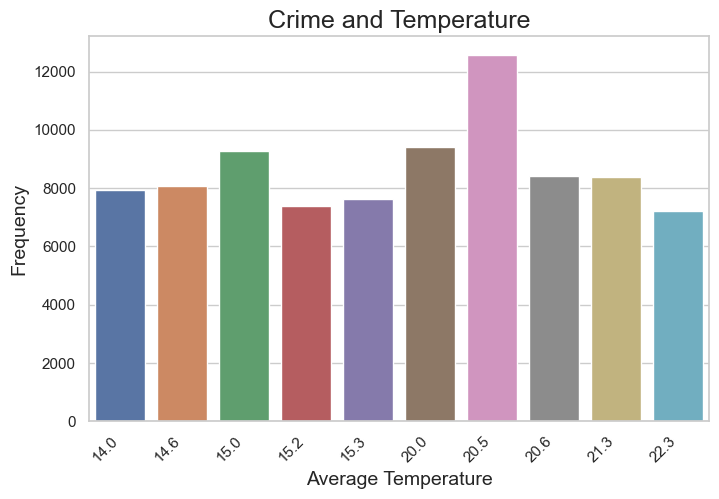

In [40]:
# Set a custom color palette
sns.set_palette("pastel")

# Set the background style to whitegrid
sns.set(style="whitegrid")

# Set a larger figure size
plt.figure(figsize=(8, 5))

# Plot a bar chart of the top 10 average temperatures and their frequencies in crimes
top_temp = df_final['temp'].value_counts().head(10)
sns.barplot(x=top_temp.index, y=top_temp.values)
plt.title('Crime and Temperature', fontsize=18)
plt.xlabel('Average Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

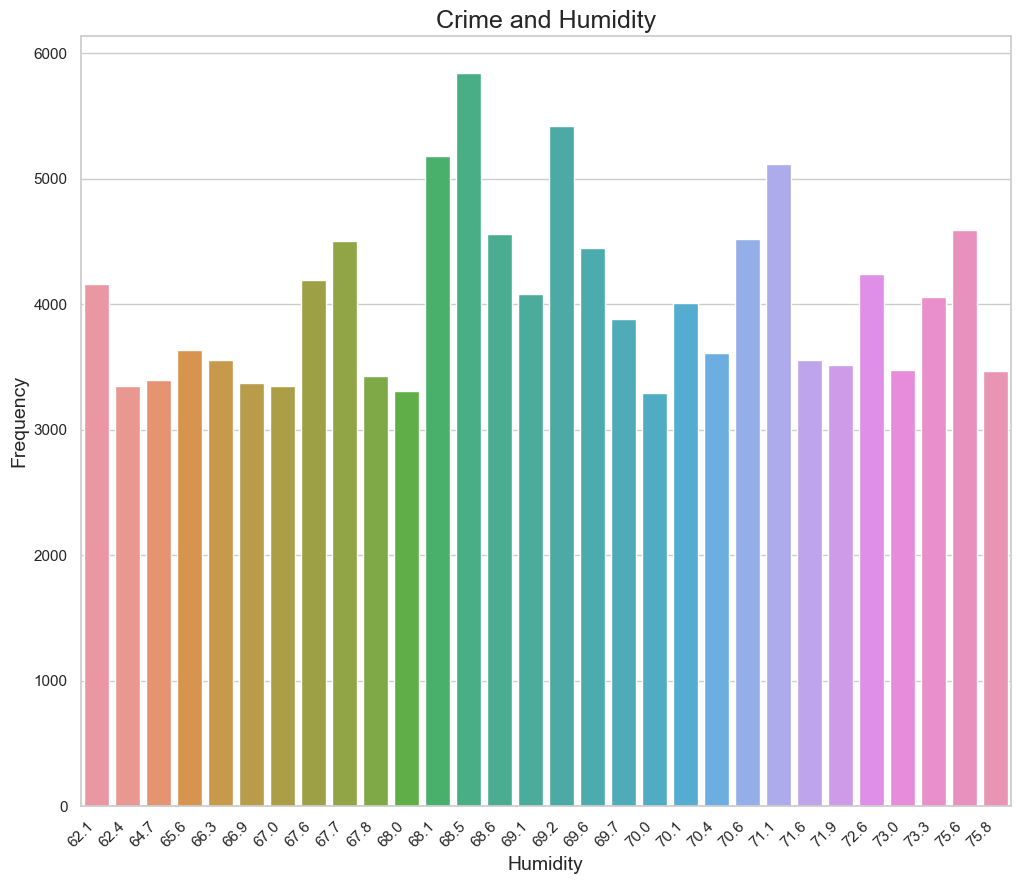

In [41]:
# Set a larger figure size for the next plot
plt.figure(figsize=(12, 10))

# Plot a bar chart of the top 30 humidity levels and their frequencies in crimes
top_humidity = df_final['humidity'].value_counts().head(30)
sns.barplot(x=top_humidity.index, y=top_humidity.values)
plt.title('Crime and Humidity', fontsize=18)
plt.xlabel('Humidity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

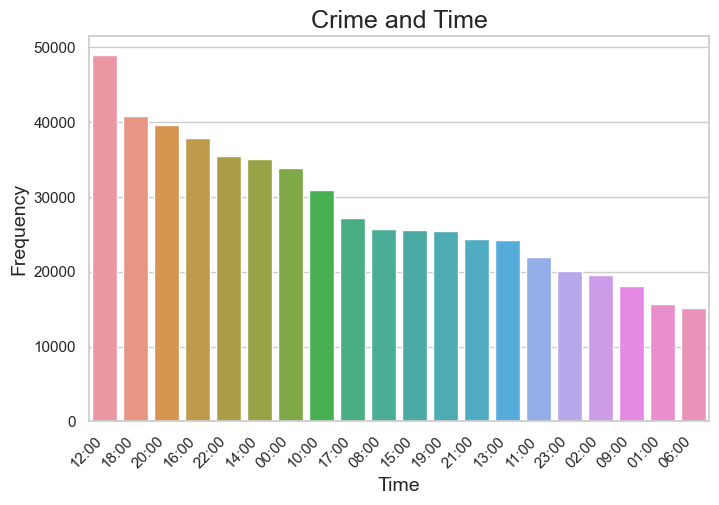

In [42]:
# Set a larger figure size for the next plot
plt.figure(figsize=(8, 5))

# Plot a bar chart of the top 20 rounded crime times and their frequencies
top_time = df_final['rounded_crime_time'].value_counts().head(20)
sns.barplot(x=top_time.index, y=top_time.values)
plt.title('Crime and Time', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

In [43]:
# Remove rows where the crime time is '12:00' as it is considered an outlier
df_final = df_final[df_final['rounded_crime_time'] != '12:00']

# Display the count of rows where the crime time is '12:00' after removal (should be 0)
count_rows_with_12_00 = df_final[df_final['rounded_crime_time'] == '12:00'].shape[0]
print("Count of rows with crime time '12:00' after removal:", count_rows_with_12_00)

df_final.shape # (561983, 33)

Count of rows with crime time '12:00' after removal: 0


(561983, 33)

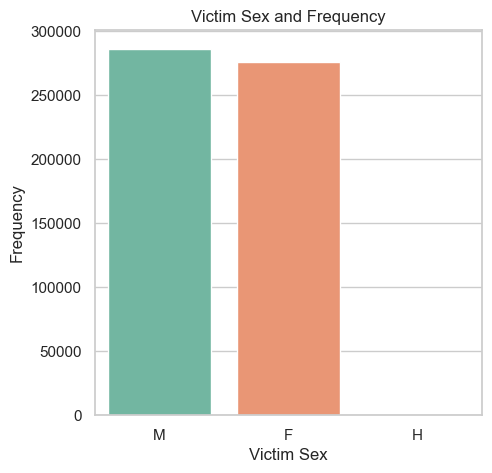

In [44]:
# Plot a bar chart of victim sex and its frequency
plt.figure(figsize=(5, 5))
victim_sex_freq = df_final['vict_sex'].value_counts()
sns.barplot(x=victim_sex_freq.index, y=victim_sex_freq.values, palette="Set2")
plt.title('Victim Sex and Frequency')
plt.xlabel('Victim Sex')
plt.ylabel('Frequency')
plt.show()

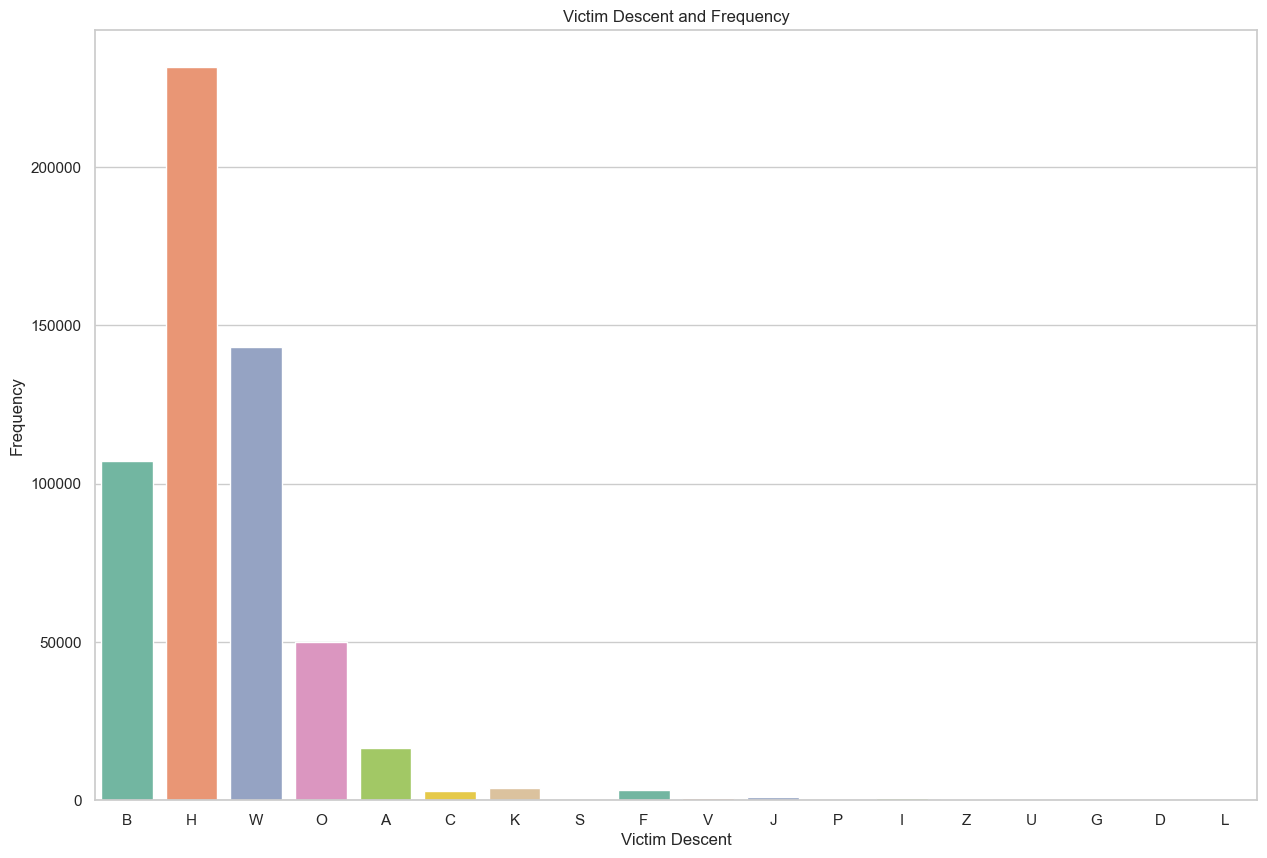

In [45]:
# Plot a countplot of victim descent and its frequency
plt.figure(figsize=(15, 10))
sns.countplot(data=df_final, x='vict_descent', palette="Set2")
plt.title('Victim Descent and Frequency')
plt.xlabel('Victim Descent')
plt.ylabel('Frequency')
plt.show()

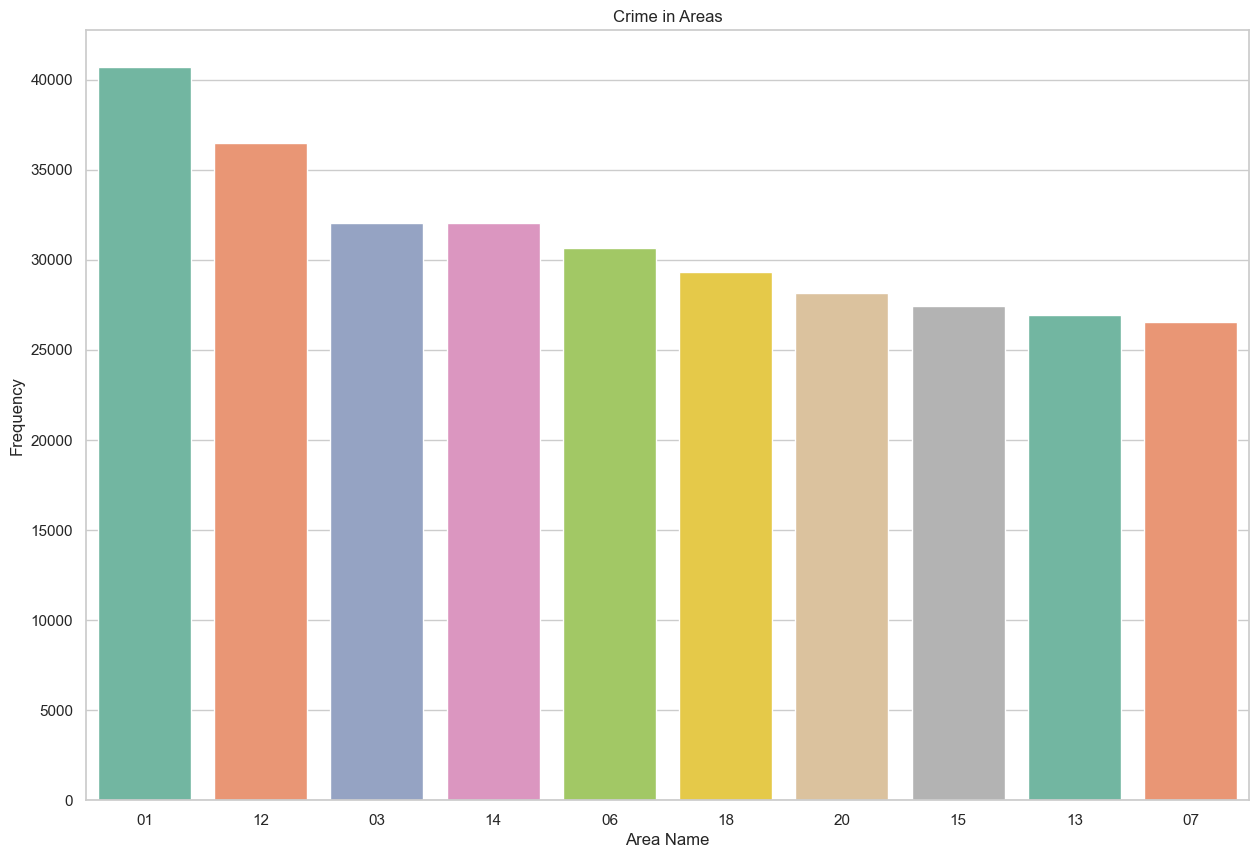

In [46]:
# Plot a bar chart of the top 10 areas and the frequency of crimes committed in them
plt.figure(figsize=(15, 10))
top_areas = df_final['area'].value_counts().head(10)
sns.barplot(x=top_areas.index, y=top_areas.values, palette="Set2")
plt.title('Crime in Areas')
plt.xlabel('Area Name')
plt.ylabel('Frequency')
plt.show()

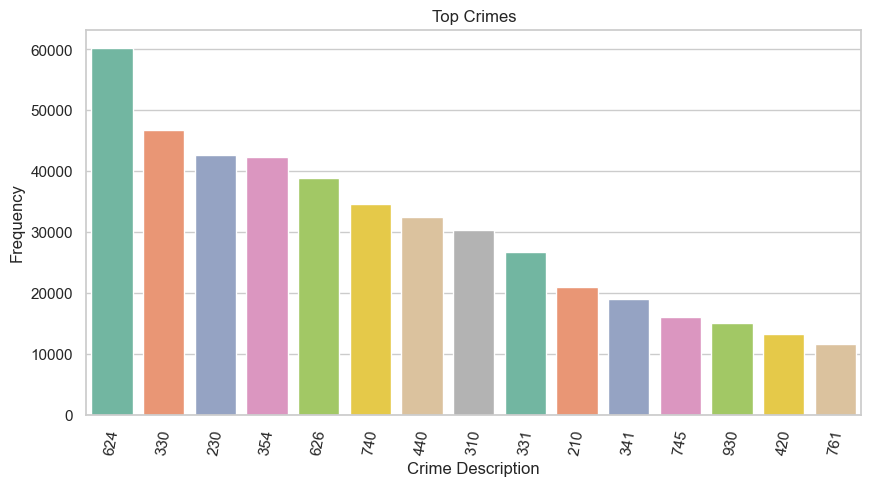

In [47]:
# Plot a bar chart of the top 15 crimes and their frequencies
plt.figure(figsize=(10, 5))
top_crimes = df_final['crm_cd'].value_counts().head(15)
sns.barplot(x=top_crimes.index, y=top_crimes.values, palette="Set2")
plt.title('Top Crimes')
plt.xlabel('Crime Description')
plt.ylabel('Frequency')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=80)
plt.show()

In [48]:
# Calculate the percentage of data covered by the top 13 crime categories
percent_data = (df_final['crm_cd'].value_counts().head(13).sum() / df_final.shape[0]) * 100
percent_data

75.82560326557922

In [49]:
# Identify the top 13 crime categories
top_crime_codes = df_final['crm_cd'].value_counts().head(13).index.tolist()

# Filter the DataFrame based on the top crime codes
df_final = df_final[df_final['crm_cd'].isin(top_crime_codes)]

df_final['crm_cd'].value_counts()

df_final.shape # (426127, 33)

(426127, 33)

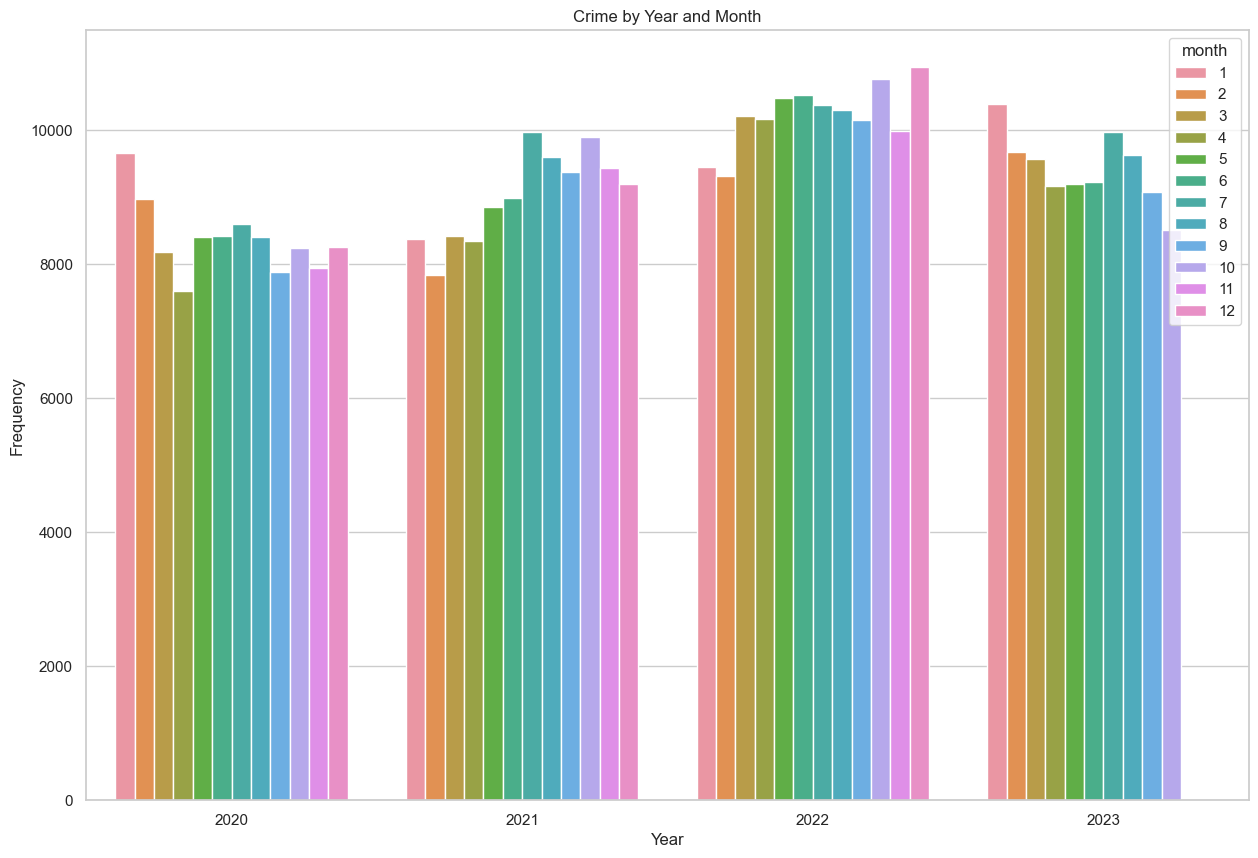

In [50]:
# Plot crimes committed by year and month
plt.figure(figsize=(15, 10))
sns.countplot(x='year', hue='month', data=df_final)
plt.title('Crime by Year and Month')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

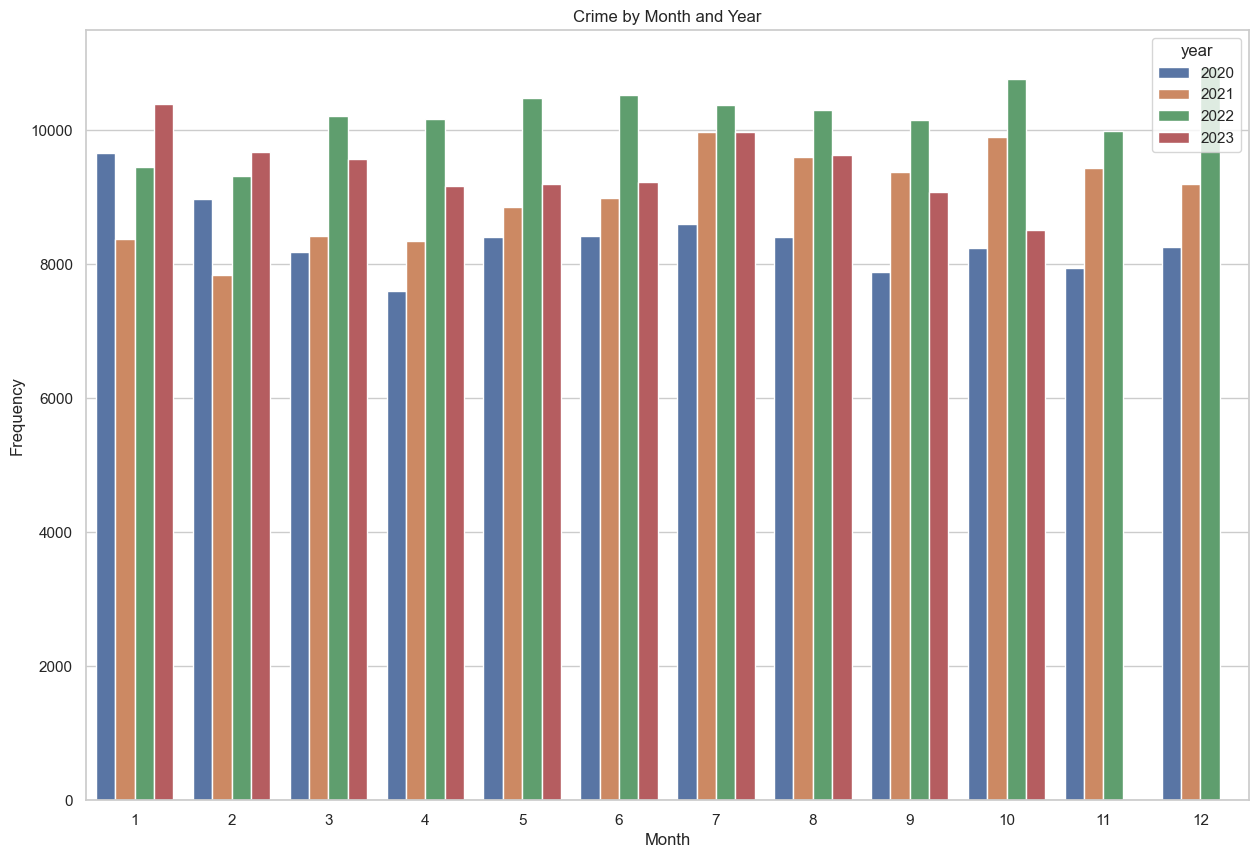

In [51]:
# Plot crimes committed by month and year
plt.figure(figsize=(15, 10))
sns.countplot(x='month', hue='year', data=df_final)
plt.title('Crime by Month and Year')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

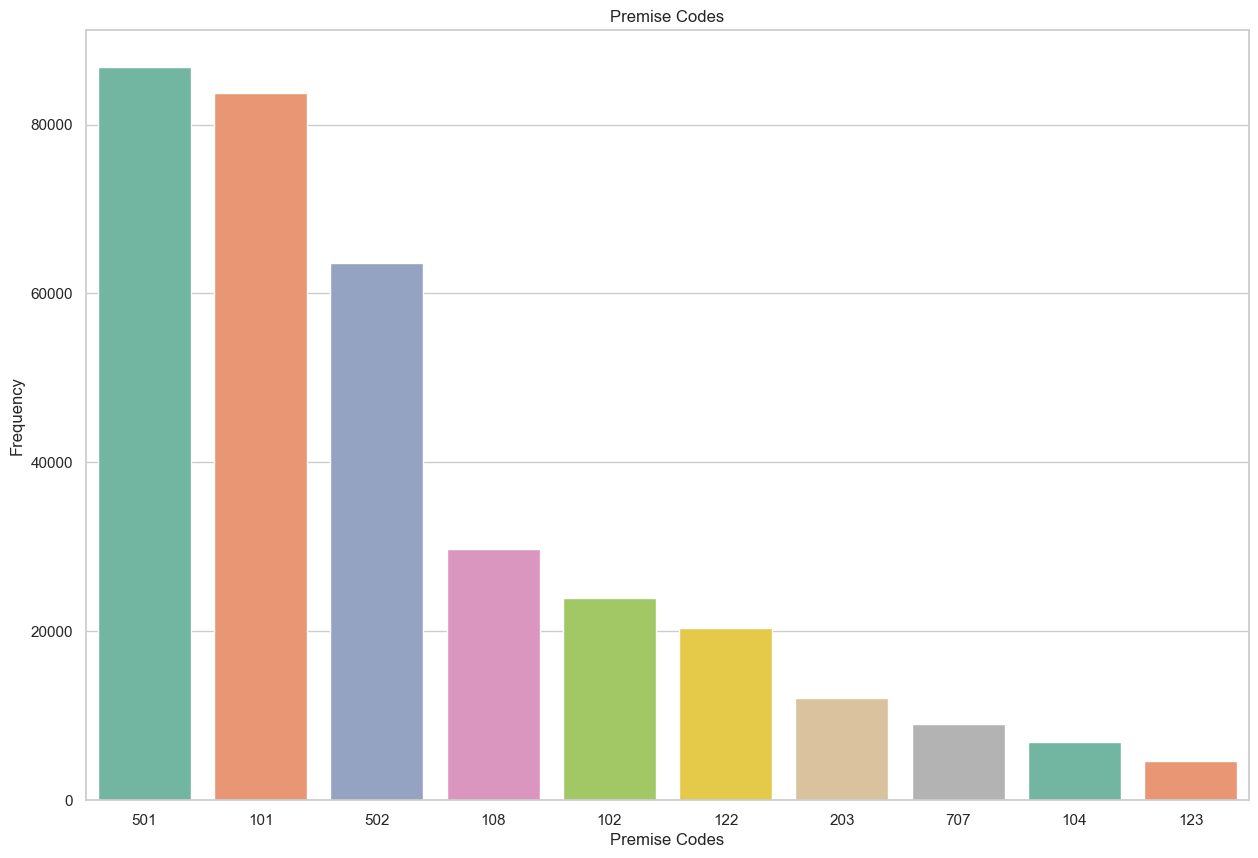

In [52]:
# Plot premise codes and their frequencies for the top 10 premises
plt.figure(figsize=(15, 10))
top_premis = df_final['premis_cd'].value_counts().head(10)
sns.barplot(x=top_premis.index, y=top_premis.values, palette="Set2")
plt.title('Premise Codes')
plt.xlabel('Premise Codes')
plt.ylabel('Frequency')
plt.show()

In [53]:
# Display the count of unique values for 'premis_cd' column
df_final['premis_cd'].value_counts()

501    86825
101    83683
502    63612
108    29721
102    23903
       ...  
898        1
803        1
976        1
973        1
892        1
Name: premis_cd, Length: 309, dtype: int64

In [54]:
# Display the unique values of the 'premis_cd' column
df_final['premis_cd'].unique()

array(['501', '102', '517', '101', '203', '903', '244', '108', '502',
       '503', '103', '104', '251', '122', '202', '151', '507', '707',
       '210', '510', '727', '221', '146', '119', '738', '208', '123',
       '504', '109', '701', '212', '710', '217', '117', '505', '406',
       '834', '735', '207', '801', '222', '121', '401', '411', '750',
       '725', '757', '733', '902', '147', '114', '726', '110', '702',
       '910', '252', '602', '120', '404', '213', '301', '511', '509',
       '247', '704', '751', '135', '516', '402', '810', '717', '518',
       '417', '403', '214', '804', '124', '232', '158', '716', '405',
       '248', '719', '254', '741', '708', '118', '514', '243', '229',
       '107', '201', '605', '152', '706', '721', '138', '145', '732',
       '728', '230', '729', '116', '140', '913', '911', '239', '148',
       '736', '920', '515', '218', '607', '506', '901', '916', '753',
       '905', '944', '909', '256', '722', '416', '802', '956', '935',
       '835', '249',

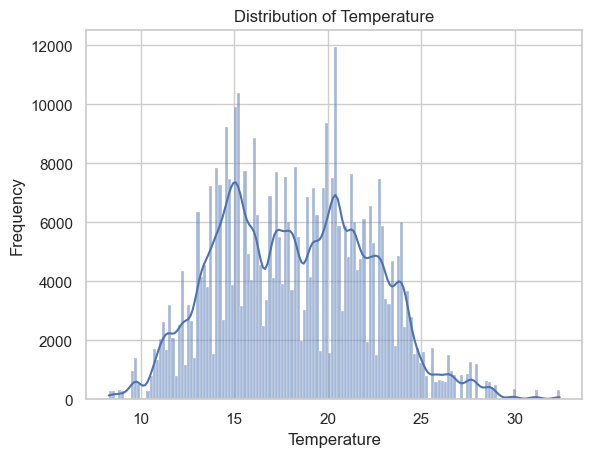

In [55]:
# Plot a histogram of the distribution of temperature
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df_final, x="temp", kde=True)
plt.title("Distribution of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [56]:
# Display column names, unique values, and their counts
for i in df_final.columns:
    print(i)
    print(df_final[i].value_counts())
    print("Unique Values:", len(df_final[i].unique()))

area
01    31979
12    27500
14    24482
06    23791
03    23359
18    22477
20    21688
13    21082
15    20824
07    20282
02    20053
08    19693
09    19201
10    17799
11    17600
21    16856
17    16429
19    16277
05    16018
04    14581
16    14156
Name: area, dtype: int64
Unique Values: 21
crm_cd
624    60219
330    46736
230    42589
354    42377
626    38885
740    34670
440    32394
310    30354
331    26660
210    21015
341    19062
745    16111
930    15055
Name: crm_cd, dtype: int64
Unique Values: 13
vict_age
30    13421
31    12938
29    12875
28    12670
32    12556
      ...  
94       58
95       55
96       52
98       42
97       35
Name: vict_age, Length: 98, dtype: int64
Unique Values: 98
vict_sex
M    225011
F    201048
H        68
Name: vict_sex, dtype: int64
Unique Values: 3
vict_descent
H    171321
W    109280
B     82536
O     38671
A     12569
K      3516
F      2802
C      2521
J       928
V       658
I       563
Z       318
P       171
U       103
D      

In [ ]:
#save final data to csv
#df_final.to_csv(r'D:\Google Drive\McGill\Fall Semester\INSY 662\Team Project\Data\final_data_raw.csv', index=False)

Feature Selection, Relation between variables, choosing predictors for modelling

In [57]:
# Read the final data from the CSV file
df_final = pd.read_csv('final_data_raw.csv')
df_final.shape # (446303, 33)

(446303, 33)

In [183]:
# Convert 'rounded_crime_time' to a numerical feature 'hour_crime_occ'
df_final['hour_crime_occ'] = pd.to_datetime(df_final['rounded_crime_time']).dt.hour

In [184]:
# Drop unnecessary variables
df_final.drop(columns=['year', 'date_time_crime_occ', 'sunrise_time', 'sunset_time', 'rounded_crime_time', 'precipprob', 'precipcover'], inplace=True)
df_final.shape # (446303, 27)

(446303, 27)

In [185]:
# Display the counts of unique values for 'crm_cd'
print(df_final['crm_cd'].value_counts())

624    61000
330    47482
230    43881
354    42792
626    39261
740    38487
310    35961
440    34041
331    27359
210    22504
341    20723
745    17451
930    15361
Name: crm_cd, dtype: int64


In [186]:
# Group by 'crm_cd' and 'premis_cd', then find the top 7 counts for each 'crm_cd'
top_premis = df_final.groupby('crm_cd')['premis_cd'].value_counts().groupby(level=0, group_keys=False).nlargest(7)
top_premis

crm_cd  premis_cd
210     101          7953
        102          4292
        108          1870
        502           938
        501           845
                     ... 
930     101          2007
        203           913
        102           876
        108           638
        210           223
Name: premis_cd, Length: 91, dtype: int64

In [187]:
# Reset the index and pivot the table for better readability
top_premis = top_premis.reset_index(name='Count')
top_premis = top_premis.pivot(index='premis_cd', columns='crm_cd', values='Count')
top_premis.fillna(0, inplace=True)
top_premis.reset_index(inplace=True)
top_premis.columns.name = None
top_premis = top_premis.sort_index(ascending=True)
top_premis.reset_index(drop=True, inplace=True)

top_premis

,premis_cd,210,230,310,330,331,341,354,440,624,626,740,745,930
0,101,7953.0,15334.0,0.0,19587.0,13531.0,1324.0,928.0,1782.0,9665.0,5095.0,6200.0,2183.0,2007.0
1,102,4292.0,6539.0,0.0,0.0,0.0,718.0,0.0,1318.0,6976.0,1717.0,0.0,287.0,876.0
2,103,0.0,926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,104,0.0,0.0,0.0,1830.0,1662.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,108,1870.0,3325.0,0.0,10583.0,4019.0,767.0,0.0,915.0,3725.0,1308.0,2468.0,814.0,638.0
5,119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0
6,120,0.0,0.0,549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,622.0,13568.0,4882.0,0.0
8,123,0.0,0.0,0.0,2641.0,733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,203,738.0,936.0,3140.0,0.0,0.0,1346.0,0.0,1691.0,3233.0,0.0,1573.0,450.0,913.0


In [188]:
# Display the selected rows based on your indices
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    selected_rows = top_premis.reset_index()[[624, 330, 230, 354, 626, 740, 440, 310, 331]]
    selected_rows.index = top_premis['premis_cd']  # Set 'premis_cd' as the index
    print(selected_rows)

               624      330      230      354      626      740     440  \
premis_cd                                                                 
101         9665.0  19587.0  15334.0    928.0   5095.0   6200.0  1782.0   
102         6976.0      0.0   6539.0      0.0   1717.0      0.0  1318.0   
103            0.0      0.0    926.0      0.0      0.0      0.0     0.0   
104            0.0   1830.0      0.0      0.0      0.0      0.0     0.0   
108         3725.0  10583.0   3325.0      0.0   1308.0   2468.0   915.0   
119            0.0      0.0      0.0      0.0      0.0      0.0  2023.0   
120            0.0      0.0      0.0      0.0      0.0      0.0     0.0   
122            0.0      0.0      0.0      0.0    622.0  13568.0     0.0   
123            0.0   2641.0      0.0      0.0      0.0      0.0     0.0   
203         3233.0      0.0    936.0      0.0      0.0   1573.0  1691.0   
210         1240.0      0.0      0.0      0.0      0.0      0.0     0.0   
212            0.0      0

In [189]:
# Display the counts of unique values for 'premis_cd'
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_final['premis_cd'].value_counts())

501    87692
101    85770
502    64732
108    30864
102    24479
122    20998
203    15611
707     9157
104     6924
210     5550
123     4699
504     3943
103     3611
109     3541
710     3440
121     3212
503     2922
119     2763
402     2756
301     2587
221     2373
602     2319
212     2022
605     1908
406     1764
116     1757
801     1510
507     1479
401     1424
750     1362
702     1360
701     1269
404     1255
505     1213
124     1211
717     1196
721     1186
403     1018
202      998
207      978
145      884
213      881
222      863
118      830
117      829
405      803
704      791
727      769
510      760
720      759
735      742
120      708
708      655
252      655
834      639
517      586
217      559
506      550
719      538
248      522
725      516
158      515
518      505
242      455
514      412
509      403
722      401
751      382
733      380
146      358
218      334
243      328
738      281
247      263
516      234
726      216
904      210

Subset data for modelling - Original dataset was too large to model on our machines

In [192]:
# Get the counts of unique values for 'premis_cd'
premis_counts = df_final['premis_cd'].value_counts()

# Print the counts of unique values for 'premis_cd'
print(premis_counts)

# Filter 'premis_cd' values with counts greater than 10000
df_final = df_final[df_final['premis_cd'].isin(premis_counts[premis_counts > 10000].index)]

# Display the shape of the dataframe after filtering
print(df_final.shape)  # Output: (330146 rows x 27 columns)

501    87692
101    85770
502    64732
108    30864
102    24479
122    20998
203    15611
Name: premis_cd, dtype: int64
(330146, 27)


In [194]:
# Display the counts of unique values for 'crm_cd' after filtering
df_final['crm_cd'].value_counts()

624    43563
626    35752
230    34983
330    34815
354    33310
740    31287
310    23921
331    21162
440    17436
210    16736
745    14576
930    12156
341    10449
Name: crm_cd, dtype: int64

In [196]:
# Choose 3000 rows of crm_cd 624, 626, 230, 330, 354, 740
df_624 = df_final[df_final['crm_cd']==624].sample(n=6000, random_state=1)
df_626 = df_final[df_final['crm_cd']==626].sample(n=6000, random_state=1)
df_230 = df_final[df_final['crm_cd']==230].sample(n=6000, random_state=1)
df_330 = df_final[df_final['crm_cd']==330].sample(n=6000, random_state=1)
df_354 = df_final[df_final['crm_cd']==354].sample(n=6000, random_state=1)
df_740 = df_final[df_final['crm_cd']==740].sample(n=6000, random_state=1)

# Combine all these dataframes into one
df_final1 = pd.concat([df_624, df_330, df_230, df_354, df_626, df_740], ignore_index=True)
df_final1.shape # (36000, 27)

(36000, 27)

In [197]:
# Display the counts of unique values for 'premis_cd' after the combination
df_final1['premis_cd'].value_counts()

101    9668
501    9227
502    6896
108    3603
122    2864
102    2627
203    1115
Name: premis_cd, dtype: int64

In [203]:
# Filter 'premis_cd' values with counts greater than 1000
premis_counts = df_final1['premis_cd'].value_counts()

df_final1 = df_final1[df_final1['premis_cd'].isin(premis_counts[premis_counts > 1000].index)] # (36000, 27)

# Display the counts of unique values for 'premis_cd' after filtering
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_final1['premis_cd'].value_counts())

101    9668
501    9227
502    6896
108    3603
122    2864
102    2627
203    1115
Name: premis_cd, dtype: int64
(36000, 27)


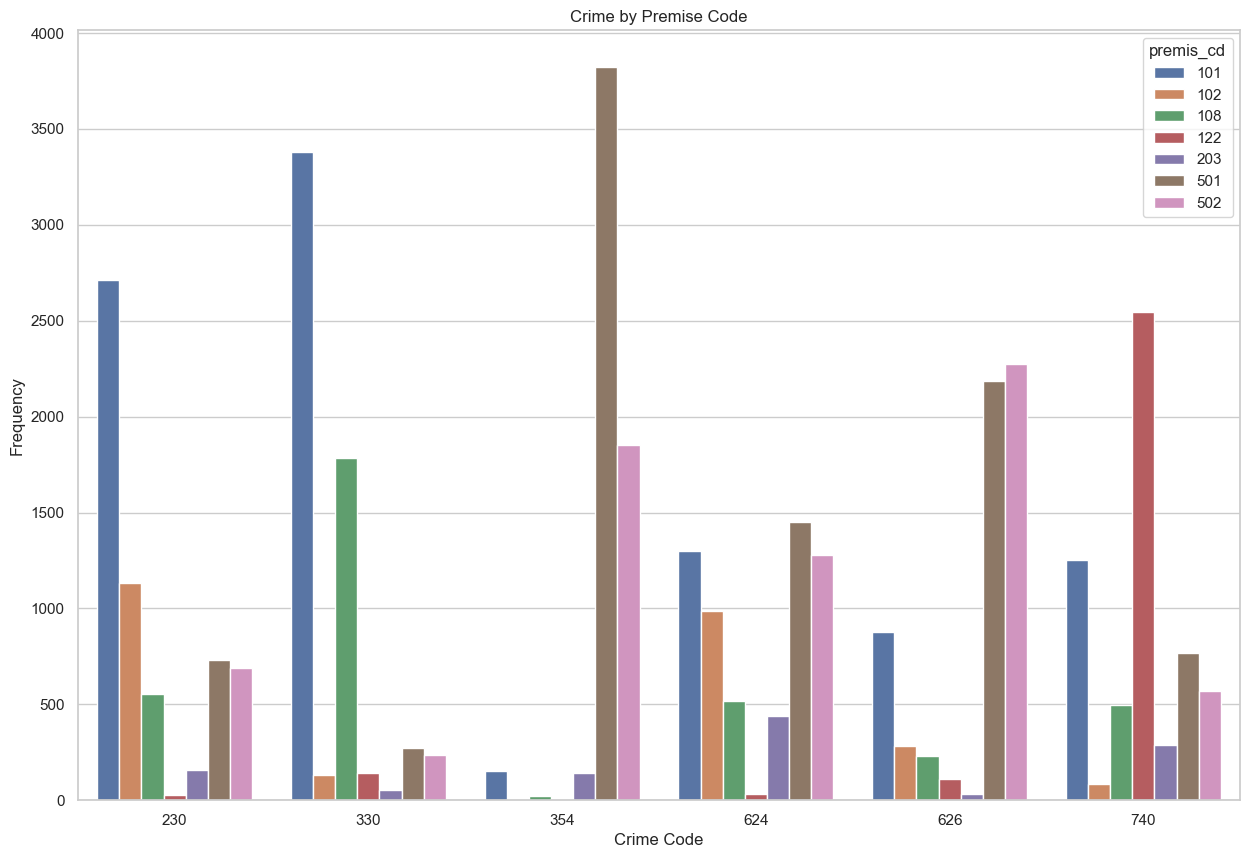

In [205]:
# Plot 'crm_cd' against 'premis_cd'
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.countplot(x='crm_cd', hue='premis_cd', data=df_final1)
plt.title('Crime by Premise Code')
plt.xlabel('Crime Code')
plt.ylabel('Frequency')
plt.show()

Remove highly correlated variables

In [210]:
# Create dummy variables for categorical columns and calculate the correlation matrix
df_final_dummified_corr_matrix = pd.get_dummies(df_final1, columns=['crm_cd', 'area', 'vict_sex', 'vict_descent', 'conditions', 'premis_cd', 'month', 'day'], drop_first=True)
corr = df_final_dummified_corr_matrix.corr()

# Set the threshold for high correlation
threshold = 0.8

# Filter the correlations
high_corr = corr[(corr > threshold) & (corr < 1.0)]

# Fill diagonal elements with NaN
np.fill_diagonal(high_corr.values, np.nan)

# Create a DataFrame with highly correlated variables
high_corr_df = pd.DataFrame(columns=["Variable 1", "Variable 2", "Correlation"])
for col in high_corr.columns:
    for index, row in high_corr[col][high_corr[col].notna()].items():
        high_corr_df = high_corr_df.append({"Variable 1": col, "Variable 2": index, "Correlation": row}, ignore_index=True)

# Display the DataFrame sorted by correlation values
print(high_corr_df.sort_values(by="Correlation", ascending=False))

        Variable 1      Variable 2  Correlation
6   solarradiation     solarenergy     0.999882
8      solarenergy  solarradiation     0.999882
7   solarradiation         uvindex     0.941469
10         uvindex  solarradiation     0.941469
9      solarenergy         uvindex     0.941299
11         uvindex     solarenergy     0.941299
0          tempmax            temp     0.933074
3             temp         tempmax     0.933074
1          tempmin            temp     0.915709
4             temp         tempmin     0.915709
2          tempmin             dew     0.809379
5              dew         tempmin     0.809379


/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_21345/1108386434.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_df = high_corr_df.append({"Variable 1": col, "Variable 2": index, "Correlation": row}, ignore_index=True)
/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_21345/1108386434.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_df = high_corr_df.append({"Variable 1": col, "Variable 2": index, "Correlation": row}, ignore_index=True)
/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_21345/1108386434.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  high_corr_df = high_corr_df.append({"Variable 1": col, "Variable 2": index, "Correlation": row}, ignore_index=True

In [211]:
# Remove highly correlated variables dew, tempmin, tempmax, solarenergy, solarradiation
df_final2 = df_final1.drop(columns=['dew', 'tempmin', 'tempmax', 'solarenergy', 'solarradiation'])

# Display the first 5 rows of the DataFrame after removal
display(HTML(df_final2.head().to_html()))

# Display the shape of the DataFrame after removal
print(df_final2.shape)

,area,crm_cd,vict_age,vict_sex,vict_descent,premis_cd,month,day,temp,humidity,precip,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex,moonphase,conditions,sunset_time_difference,sunrise_time_difference,hour_crime_occ
0,20,624,35,M,W,108,8,11,22.3,73.4,0.0,17.8,235.5,1014.8,66.2,15.9,7,0.84,Partially cloudy,19,6,0
1,4,624,30,M,O,102,6,8,24.8,17.5,0.0,15.4,323.9,1014.0,0.5,16.0,10,0.60,Clear,10,4,10
2,17,624,23,M,H,502,7,30,22.3,71.7,0.0,10.0,244.5,1013.0,7.8,16.0,6,0.07,Clear,17,3,3
3,20,624,58,F,W,501,3,31,18.6,55.1,0.0,12.0,262.8,1015.8,2.8,15.8,6,0.25,Clear,2,11,17
4,12,624,22,F,H,501,8,14,24.3,56.6,0.0,14.2,246.6,1011.9,1.9,16.0,9,0.59,Clear,10,3,10


(36000, 22)


In [ ]:
#save final data to csv
#df_final2.to_csv(r'D:\Google Drive\McGill\Fall Semester\INSY 662\Team Project\Data\final_data.csv', index=False)

In [212]:
# Create dummy variables for categorical columns in the modified DataFrame
df_final_dummified = pd.get_dummies(df_final2, columns=['area', 'vict_sex', 'vict_descent', 'conditions', 'premis_cd', 'month', 'day'], drop_first=True)
df_final_dummified.shape # (36000, 107)

(36000, 107)

In [ ]:
# Save the final dummified data to a CSV file
# df_final_dummified.to_csv(r'D:\Google Drive\McGill\Fall Semester\INSY 662\Team Project\Data\final_data_dummified.csv', index=False)

# Modelling

The below lines of code involves building and evaluating two classification models, a Decision Tree and a Random Forest, to predict crime categories (crm_cd). Features and the target variable are extracted from the dummified dataset. The data is split into training and testing sets, and both models are trained and evaluated using classification metrics, including accuracy and recall. The Decision Tree and Random Forest models aim to predict crime categories based on various dummified features, providing insights into the effectiveness of these models for crime classification.

In [2]:
# Read the original and dummified datasets
df_final2 = pd.read_csv('final_data.csv') # (36000, 22)
df_final_dummified = pd.read_csv('final_data_dummified.csv') # (36000, 106)

In [3]:
# Display the summary statistics for the original dataset
df_final2.describe()

,area,crm_cd,vict_age,premis_cd,month,day,temp,humidity,precip,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex,moonphase,sunset_time_difference,sunrise_time_difference,hour_crime_occ
count,36000.000000,36000.0000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,10.679917,484.0000,39.280944,286.375694,6.281194,14.815778,18.315719,62.535519,0.768589,13.700825,239.287092,1014.867453,28.137922,14.504392,7.049111,0.474590,6.851833,8.558611,12.833528
std,6.266959,187.2778,14.459539,194.978431,3.344588,9.118570,4.038363,14.157893,4.419710,4.834342,66.029615,3.767919,30.039360,2.178238,2.322024,0.286296,5.761382,5.004457,7.173177
min,1.000000,230.0000,2.000000,101.000000,1.000000,1.000000,8.300000,15.000000,0.000000,1.300000,0.000000,1001.000000,0.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,330.0000,28.000000,101.000000,3.000000,7.000000,15.100000,55.800000,0.000000,10.300000,233.900000,1012.300000,2.000000,13.900000,6.000000,0.240000,2.000000,4.000000,7.000000
50%,11.000000,489.0000,36.000000,122.000000,6.000000,15.000000,18.200000,66.700000,0.000000,12.700000,254.300000,1014.300000,15.900000,15.500000,7.000000,0.470000,5.000000,8.000000,14.000000
75%,16.000000,626.0000,49.000000,501.000000,9.000000,23.000000,21.300000,71.800000,0.000000,16.700000,269.200000,1017.300000,50.500000,16.000000,9.000000,0.720000,11.000000,13.000000,19.000000
max,21.000000,740.0000,99.000000,502.000000,12.000000,31.000000,32.400000,93.900000,69.600000,42.800000,358.600000,1026.500000,100.000000,16.000000,10.000000,0.980000,20.000000,18.000000,23.000000


In [217]:
# Display the counts of unique values for the 'crm_cd' column
df_final2['crm_cd'].value_counts()

624    6000
330    6000
230    6000
354    6000
626    6000
740    6000
Name: crm_cd, dtype: int64

In [218]:
# Display the counts of unique values for the 'premis_cd' column
df_final2['premis_cd'].value_counts()

101    9559
501    9278
502    6896
108    3644
122    3003
102    2582
203    1038
Name: premis_cd, dtype: int64

In [221]:
# Extract features (X) and target variable (y) from the dummified dataset
# Dummified variables: ['area', 'vict_sex', 'vict_descent', 'conditions', 'premis_cd', 'month', 'day']
X = df_final_dummified.drop(columns='crm_cd')
y = df_final_dummified['crm_cd']

In [222]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [223]:
# Import metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, recall_score

In [224]:
# Build a Decision Tree model and measure the accuracy score
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

# Print the classification report for Decision Tree model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         230       0.31      0.31      0.31      2119
         330       0.43      0.42      0.42      2119
         354       0.48      0.49      0.49      2069
         624       0.26      0.25      0.25      2092
         626       0.33      0.35      0.34      2032
         740       0.49      0.47      0.48      2169

    accuracy                           0.38     12600
   macro avg       0.38      0.38      0.38     12600
weighted avg       0.38      0.38      0.38     12600



In [225]:
# Build a Random Forest model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

# Print the classification report for Random Forest model
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

         230       0.46      0.42      0.44      2119
         330       0.49      0.66      0.56      2119
         354       0.53      0.74      0.62      2069
         624       0.38      0.24      0.30      2092
         626       0.42      0.50      0.45      2032
         740       0.82      0.47      0.60      2169

    accuracy                           0.50     12600
   macro avg       0.52      0.50      0.50     12600
weighted avg       0.52      0.50      0.50     12600



In [227]:
# Calculate and print the macro-average recall score for the Random Forest model in percentage form
macro_recall_percentage = recall_score(y_test, rfc_pred, average='macro') * 100
print(f'Macro-Average Recall Score: {macro_recall_percentage:.2f}%')

Macro-Average Recall Score: 50.40%


## Dimension Reduction: Using Principal Component Analysis

The below lines of code perform dimensionality reduction using Principal Component Analysis (PCA) with 95% variance retention. A Scree Plot is generated to aid in selecting 78 principal components. The data is standardized and split into training and testing sets. Two models are trained and evaluated: a Neural Network (MLP) model with hyperparameter tuning using GridSearchCV, and a Random Forest model with 2000 estimators. The models are assessed based on classification metrics, emphasizing macro-average recall as a key evaluation criterion.

In [228]:
# Standardize data using MINMAX scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

In [229]:
# Perform PCA with 95% variance explained
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_std)

PCA(n_components=0.95)

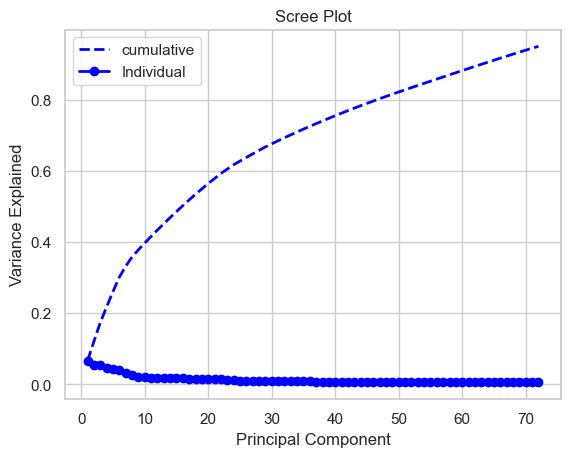

In [230]:
# Plot Scree Plot to visualize explained variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + cum_explained_var[i-1])

import matplotlib.pyplot as plt
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, cum_explained_var, linestyle='--', linewidth=2, color='blue', label='cumulative')
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue', label='Individual')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

In [231]:
# Choose 78 components based on the Scree Plot
# Fit the model and split the data into training and testing sets
pca = PCA(n_components=78)
X_pca = pca.fit_transform(X_std)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.35, random_state=42)

In [233]:
# Neural Network (MLP) model from MLPClassifier with GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, recall_score

param_grid = {
    'hidden_layer_sizes': [
                (100, 100, 100, 100, 100, 100),
        (150, 150, 150, 150, 150, 150)
    ],
    'max_iter': [600, 800],
}

mlp = MLPClassifier()

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='recall_macro', n_jobs=-1)
grid_search.fit(X_pca_train, y_train)

best_params = grid_search.best_params_
best_mlp = grid_search.best_estimator_

mlp_pred = best_mlp.predict(X_pca_test)

# Print the results for MLP model
print("Best Parameters:", best_params)
print("Classification Report:")
print(classification_report(y_test, mlp_pred))
print("Macro-average Recall:", recall_score(y_test, mlp_pred, average='macro'))

KeyboardInterrupt: 

In [234]:
# Random Forest model with PCA
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=2000)
rfc.fit(X_pca_train, y_train)
rfc_pred = rfc.predict(X_pca_test)

# Print the results for Random Forest model
print("Classification Report:")
print(classification_report(y_test, rfc_pred))
print("Macro-average Recall:", recall_score(y_test, rfc_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

         230       0.46      0.39      0.42      2119
         330       0.47      0.70      0.56      2119
         354       0.52      0.75      0.61      2069
         624       0.42      0.23      0.30      2092
         626       0.42      0.48      0.44      2032
         740       0.85      0.47      0.60      2169

    accuracy                           0.50     12600
   macro avg       0.52      0.50      0.49     12600
weighted avg       0.52      0.50      0.49     12600

Macro-average Recall: 0.5014616838248365


## Feature Selection: Using Lasso

In [235]:
# Read dummified data
df_final_dummified = pd.read_csv('final_data_dummified.csv')

In [236]:
# Separate predictors (X) and target variable (y)
X = df_final_dummified.drop(columns='crm_cd')
y = df_final_dummified['crm_cd']

In [237]:
# Standardize data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

In [238]:
# Run Lasso regression with alpha 0.1
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
model = lasso.fit(X_std, y)

In [239]:
# Create a DataFrame with predictors and their coefficients
all_predictor = pd.DataFrame(list(zip(X.columns, model.coef_)), columns=['predictor', 'coefficient'])

# Select predictors with non-zero coefficients
non_zero_coeff_predictors = all_predictor[all_predictor['coefficient'] != 0]

# Select predictors with zero coefficients
zero_coeff_predictors = all_predictor[all_predictor['coefficient'] == 0]

In [240]:
# Drop columns with zero coefficients from training and test sets
X_lasso_train = X_train.drop(columns=zero_coeff_predictors['predictor'].tolist())
X_lasso_test = X_test.drop(columns=zero_coeff_predictors['predictor'].tolist())

In [241]:
# Standardize the Lasso-selected data using MinMaxScaler
X_lasso_train_std = scaler.fit_transform(X_lasso_train)
X_lasso_test_std = scaler.fit_transform(X_lasso_test)

In [242]:
# Random Forest Classifier with default parameters
rfc = RandomForestClassifier(n_estimators=2500, max_depth=None, min_samples_split=2)
rfc.fit(X_lasso_train_std, y_train)
rfc_pred = rfc.predict(X_lasso_test_std)

# Print classification report and macro-average recall for Random Forest
print("Classification Report:")
print(classification_report(y_test, rfc_pred))
print("Macro-average Recall:", recall_score(y_test, rfc_pred, average='macro'))


Classification Report:
              precision    recall  f1-score   support

         230       0.46      0.39      0.42      2119
         330       0.48      0.66      0.55      2119
         354       0.53      0.73      0.61      2069
         624       0.37      0.24      0.29      2092
         626       0.41      0.49      0.45      2032
         740       0.84      0.47      0.60      2169

    accuracy                           0.50     12600
   macro avg       0.51      0.50      0.49     12600
weighted avg       0.52      0.50      0.49     12600

Macro-average Recall: 0.49630745983272845


In [243]:
# Label encode crime codes
label_mapping = {230: 0, 330: 1, 354: 2, 624: 3, 626: 4, 740: 5}
y_train_encoded = y_train.map(label_mapping)
y_test_encoded = y_test.map(label_mapping)

In [244]:
y_train_encoded.value_counts()

4    3968
2    3931
3    3908
0    3881
1    3881
5    3831
Name: crm_cd, dtype: int64

In [246]:
# XGBoost Classifier with Lasso-selected features
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=2500, learning_rate=0.05, max_depth=None, random_state=42, n_jobs=-1)
xgb_model.fit(X_lasso_train_std, y_train_encoded)
xgb_pred = xgb_model.predict(X_lasso_test_std)

# Print classification report and macro-average recall for XGBoost
print("Classification Report:")
print(classification_report(y_test_encoded, xgb_pred))
print("Macro-average Recall:", recall_score(y_test_encoded, xgb_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.38      0.39      2119
           1       0.49      0.57      0.53      2119
           2       0.57      0.66      0.61      2069
           3       0.32      0.27      0.30      2092
           4       0.40      0.45      0.42      2032
           5       0.66      0.50      0.57      2169

    accuracy                           0.47     12600
   macro avg       0.47      0.47      0.47     12600
weighted avg       0.47      0.47      0.47     12600

Macro-average Recall: 0.4720797640671946


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

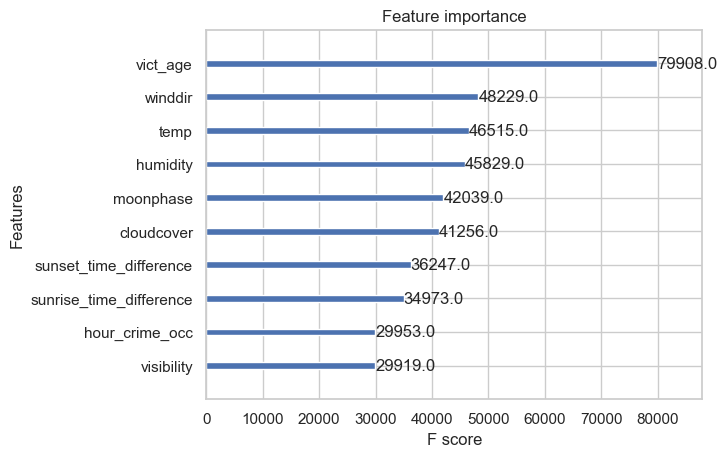

In [247]:
# Import the necessary functions from xgboost
from xgboost import plot_importance

# Get the feature names
feature_names = X_lasso_train.columns.tolist()

# Set the feature names for the XGBoost model
xgb_model.get_booster().feature_names = feature_names

# Plot the importance of the top 10 features
plot_importance(xgb_model, max_num_features=10)

In [248]:
# Artificial Neural Network (ANN) with Lasso-selected features
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'hidden_layer_sizes': [(200, 200, 200, 200, 200, 200), (100, 100, 100, 100, 100, 100, 100)],
              'max_iter': [800, 1000]}
mlp = MLPClassifier()
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='recall_macro', n_jobs=-1)
grid_search.fit(X_lasso_train_std, y_train)

# Get the best parameters and the best ANN model
best_params = grid_search.best_params_
best_mlp = grid_search.best_estimator_

# Make predictions using the best ANN model
mlp_pred = best_mlp.predict(X_lasso_test_std)

# Print best parameters, classification report, and macro-average recall for ANN
print("Best Parameters:", best_params)
print("Classification Report:")
print(classification_report(y_test, mlp_pred))
print("Macro-average Recall:", recall_score(y_test, mlp_pred, average='macro'))

KeyboardInterrupt: 

Model with 3 crime codes that showed highest accuracy and recall score before

In [4]:
# Copy the DataFrame for processing
df_final3 = df_final2.copy() # (36000, 22)

In [5]:
# Select only crime codes 330, 624, 230
df1 = df_final3[df_final3["crm_cd"] == 330]
df2 = df_final3[df_final3["crm_cd"] == 624]
df3 = df_final3[df_final3["crm_cd"] == 230]
df_final4 = pd.concat([df1, df2, df3], ignore_index=True)

In [6]:
# Display the first few rows of the DataFrame
df_final4.head()

,area,crm_cd,vict_age,vict_sex,vict_descent,premis_cd,month,day,temp,humidity,...,winddir,sealevelpressure,cloudcover,visibility,uvindex,moonphase,conditions,sunset_time_difference,sunrise_time_difference,hour_crime_occ
0,15,330,38,F,H,101,12,19,11.8,52.6,...,346.3,1019.4,0.4,15.3,6,0.52,Clear,6,16,22
1,2,330,54,F,H,502,1,15,12.8,84.9,...,256.3,1010.4,79.7,13.0,3,0.80,"Rain, Partially cloudy",8,2,9
2,9,330,42,M,F,502,5,27,17.7,67.3,...,256.0,1015.7,53.8,16.0,9,0.91,Partially cloudy,3,11,17
3,1,330,29,F,W,108,5,2,14.6,62.7,...,238.2,1012.8,47.4,15.9,10,0.41,Partially cloudy,1,13,19
4,3,330,24,M,H,101,8,20,23.1,83.6,...,338.9,1003.0,86.2,10.3,1,0.15,"Rain, Partially cloudy",1,13,19


In [256]:
# Print the count of values for the 'crm_cd' column
df_final4['crm_cd'].value_counts()

330    6000
624    6000
230    6000
Name: crm_cd, dtype: int64

In [257]:
# Print the count of values for the 'premis_cd' column
df_final4['premis_cd'].value_counts()

101    7301
108    2947
501    2492
502    2243
102    2188
203     654
122     175
Name: premis_cd, dtype: int64

In [7]:
# Keep premise codes with counts above 2000
premis_counts = df_final4['premis_cd'].value_counts()
df_final4 = df_final4[df_final4['premis_cd'].isin(premis_counts[premis_counts > 2000].index)]

df_final4.shape # (17171, 22)

(17171, 22)

In [8]:
# Perform one-hot encoding on categorical variables
df_final_dummified = pd.get_dummies(df_final4, columns=['area', 'vict_sex', 'vict_descent', 'conditions', 'premis_cd', 'month', 'day'], drop_first=True)

In [9]:
# Define a mapping from original labels to new labels for crime codes
label_mapping = {
    330: 0,
    624: 1,
    230: 2
}

# Use the mapping to encode the target variable
df_final_dummified['crm_cd'] = df_final_dummified['crm_cd'].map(label_mapping)

330: Burglary from Vehicle
624: Battery Simple Assault
230: Assault with deadly weapon

In [10]:
# Split the data into features (X) and target variable (y)
X = df_final_dummified.drop(columns='crm_cd')
y = df_final_dummified['crm_cd']

In [11]:
# Standardize data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

In [12]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.35, random_state=42)

In [264]:
# XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score

# Create an XGBoost model with specified parameters
xgb = XGBClassifier(n_estimators=3000, max_depth=None, learning_rate=0.1, n_jobs=-1)

# Fit the model on the training data
xgb.fit(X_train, y_train)

# Make predictions on the test set
xgb_pred = xgb.predict(X_test)

# Print classification report and macro-average recall for XGBoost
print("Classification Report:")
print(classification_report(y_test, xgb_pred))
print("Macro-average Recall:", recall_score(y_test, xgb_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63      2016
           1       0.53      0.50      0.51      1996
           2       0.47      0.48      0.48      1998

    accuracy                           0.54      6010
   macro avg       0.54      0.54      0.54      6010
weighted avg       0.54      0.54      0.54      6010

Macro-average Recall: 0.5410931615841436


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

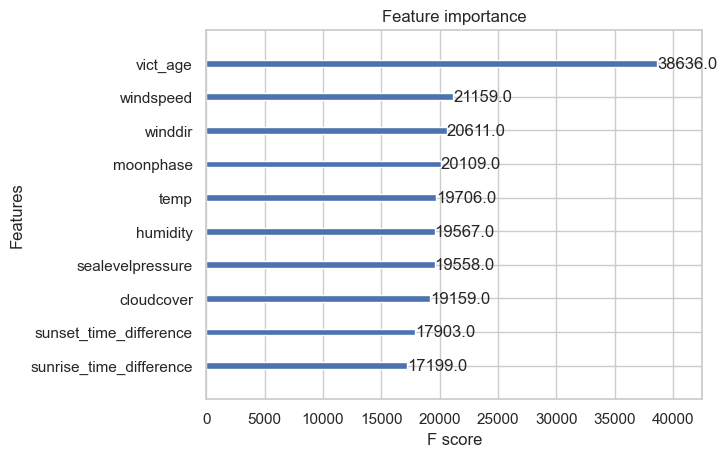

In [265]:
# Plot feature importance
from xgboost import plot_importance
feature_names = X.columns.tolist()
xgb.get_booster().feature_names = feature_names

# Plot the feature importance with actual feature names
plot_importance(xgb, max_num_features=10)

Macro-average ROC AUC: 0.726
Micro-average ROC AUC: 0.732


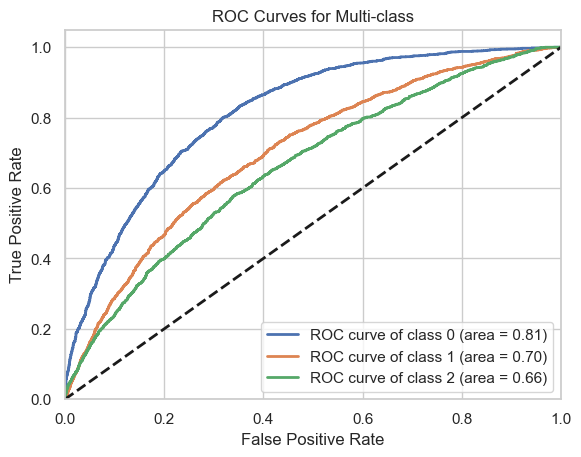

In [266]:
# Evaluate the model using ROC-AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[0, 1, 2])

# Calculate ROC AUC scores
roc_auc = roc_auc_score(y_bin, xgb.predict_proba(X_test), multi_class='ovr', average='macro')
print('Macro-average ROC AUC: %.3f' % roc_auc)

roc_auc_micro = roc_auc_score(y_bin, xgb.predict_proba(X_test), multi_class='ovr', average='micro')
print('Micro-average ROC AUC: %.3f' % roc_auc_micro)

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], xgb.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score

# Create a Random Forest model with specified parameters
rfc = RandomForestClassifier(n_estimators=3000, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_jobs=-1)

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Make predictions on the test set
rfc_pred = rfc.predict(X_test)

# Print classification report and macro-average recall for Random Forest
print("Classification Report:")
print(classification_report(y_test, rfc_pred))
print("Macro-average Recall:", recall_score(y_test, rfc_pred, average='macro'))


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      2016
           1       0.59      0.52      0.55      1996
           2       0.50      0.49      0.49      1998

    accuracy                           0.57      6010
   macro avg       0.57      0.57      0.57      6010
weighted avg       0.57      0.57      0.57      6010

Macro-average Recall: 0.570793900828971


Macro-average ROC AUC: 0.759
Micro-average ROC AUC: 0.765


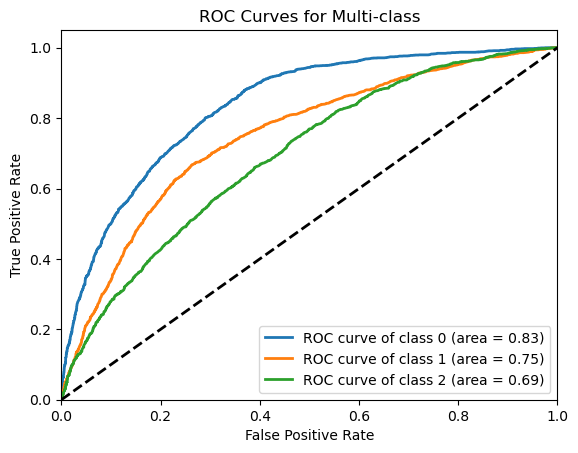

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_test, classes=[0, 1, 2])

roc_auc = roc_auc_score(y_bin, rfc.predict_proba(X_test), multi_class='ovr', average='macro')
print('Macro-average ROC AUC: %.3f' % roc_auc)

roc_auc_micro = roc_auc_score(y_bin, rfc.predict_proba(X_test), multi_class='ovr', average='micro')
print('Micro-average ROC AUC: %.3f' % roc_auc_micro)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): 
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], rfc.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(3): 
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class')
plt.legend(loc="lower right")
plt.show()

In [269]:
# Prediction for Random Forest on a sample data subset
sample_data = df_final_dummified.iloc[9000:9100, :]

In [270]:
# Display the sample data
display(HTML(sample_data.head().to_html()))

,crm_cd,vict_age,temp,humidity,precip,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex,moonphase,sunset_time_difference,sunrise_time_difference,hour_crime_occ,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,area_10,area_11,area_12,area_13,area_14,area_15,area_16,area_17,area_18,area_19,area_20,area_21,vict_sex_H,vict_sex_M,vict_descent_B,vict_descent_C,vict_descent_D,vict_descent_F,vict_descent_G,vict_descent_H,vict_descent_I,vict_descent_J,vict_descent_K,vict_descent_L,vict_descent_O,vict_descent_P,vict_descent_U,vict_descent_V,vict_descent_W,vict_descent_Z,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy",premis_cd_102,premis_cd_108,premis_cd_501,premis_cd_502,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
9453,1,83,15.9,68.2,5.28,21.3,258.1,1019.6,41.8,14.9,8,0.98,1,12,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9454,1,43,23.4,49.0,0.00,13.5,254.1,1011.1,0.2,15.8,10,0.75,20,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9455,1,44,15.6,65.5,0.00,21.1,274.3,1012.7,57.0,16.0,9,0.45,4,9,15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9456,1,60,13.2,44.0,0.00,13.1,288.7,1019.4,0.4,16.0,6,0.85,2,12,18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9457,1,57,16.8,59.4,0.00,17.1,226.3,1016.8,8.0,16.0,9,0.75,3,16,22,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [271]:
# Drop the target variable for prediction
sample_data.drop(columns='crm_cd', inplace=True)

/var/folders/vy/r5x1788j7578pp_sxh5vsqtc0000gn/T/ipykernel_21345/1374371249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data.drop(columns='crm_cd', inplace=True)


In [272]:
# Predict using the trained Random Forest model
predictions = rfc.predict(sample_data)

# Display the predicted values
predictions

/Users/kritikanayyar/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 2, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 2, 2, 0,
       1, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1,
       2, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       2, 0, 2, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2, 0,
       1, 0, 1, 0, 1, 2, 0, 2, 2, 1, 2, 0])

In [273]:
#metrics for prediction random forest
rfc.predict_proba(sample_data)

/Users/kritikanayyar/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.26566667, 0.40666667, 0.32766667],
       [0.15766667, 0.385     , 0.45733333],
       [0.21733333, 0.43066667, 0.352     ],
       [0.305     , 0.38033333, 0.31466667],
       [0.17266667, 0.41033333, 0.417     ],
       [0.39533333, 0.30366667, 0.301     ],
       [0.16333333, 0.407     , 0.42966667],
       [0.29266667, 0.38      , 0.32733333],
       [0.38366667, 0.308     , 0.30833333],
       [0.26233333, 0.37533333, 0.36233333],
       [0.22933333, 0.43266667, 0.338     ],
       [0.31033333, 0.3       , 0.38966667],
       [0.21166667, 0.45633333, 0.332     ],
       [0.18666667, 0.37166667, 0.44166667],
       [0.36233333, 0.31533333, 0.32233333],
       [0.20866667, 0.44666667, 0.34466667],
       [0.19433333, 0.406     , 0.39966667],
       [0.19733333, 0.40166667, 0.401     ],
       [0.36166667, 0.29733333, 0.341     ],
       [0.15      , 0.41366667, 0.43633333],
       [0.16266667, 0.35933333, 0.478     ],
       [0.43433333, 0.30833333, 0.25733333],
       [0.

In [275]:
# Display the count of predicted values
predicted_counts = pd.DataFrame(predictions, columns=['predicted'])
predicted_counts['predicted'].value_counts()

1    45
2    33
0    22
Name: predicted, dtype: int64